In [69]:
import operator
import pathlib

import numpy as np
import pandas as pd
import geopandas
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import colorcet
import datashader as ds
from datashader.utils import export_image

In [70]:
!pip install dataframe_image selenium

In [71]:
import dataframe_image as dfi

In [72]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [73]:
# create dict mapping fips to iso3 country codes
ccodes = pd.read_csv("gcs://frsght/datasets/country_codes.csv")
fips_iso3_map = dict(zip(ccodes['fips (geonames)'].values, ccodes['ISO3 (geonames)'].values))

In [74]:
meta = {'transformer': {'path': 'gcs://frsght/model_predictions/chad_preds.csv',
                        'fips': 'Code', 'y_pred': 'class_preds',
                        'y_pred_proba': 'preds', 'y_true': 'Spike'},
        'xgboost': {'path': 'gcs://frsght/model_predictions/diana_preds.csv',
                    'fips': 'fips', 'y_pred': 'prediction',
                    'y_pred_proba': 'probabilities', 'y_true': 'lagged_spike'},
        'ffnn': {'path': 'gcs://frsght/model_predictions/evan_preds.csv',
                 'fips': 'fips', 'y_pred': 'preds',
                 'y_pred_proba': 'preds_proba', 'y_true': 'Spike_3'},
        'ensemble': {'fips': 'fips', 'y_pred': 'y_pred',
                     'y_pred_proba': 'y_pred_proba', 'y_true': 'y_true'}}

In [75]:
pred_threshold = 0.5

In [76]:
dft = pd.read_csv("gcs://frsght/model_predictions/chad_preds.csv").drop_duplicates()
dft['model'] = 'transformer'
dft['class_preds'] = dft['preds'] > pred_threshold

dfx = pd.read_csv("gcs://frsght/model_predictions/diana_preds.csv").drop_duplicates()
dfx['yearmonth'] = pd.to_datetime(dfx['embedding_window']).dt.strftime("%Y%m")
dfx['model'] = 'xgboost'
dfx['prediction'] = dfx['probabilities'] > pred_threshold

dfn = pd.read_csv("gcs://frsght/model_predictions/evan_preds.csv").drop_duplicates()
dfx['yearmonth'] = pd.to_datetime(dfx['embedding_window']).dt.strftime("%Y%m")
dfn['model'] = 'ffnn'
dfn['preds'] = dfn['preds_proba'] > pred_threshold

In [77]:
dfs = {'transformer': dft, 'xgboost': dfx, 'ffnn': dfn}#, 'ensemble': dfe}

>>>  transformer (615, 20)
[[371 158]
 [ 46  40]] 

              precision    recall  f1-score   support

       False       0.89      0.70      0.78       529
        True       0.20      0.47      0.28        86

    accuracy                           0.67       615
   macro avg       0.55      0.58      0.53       615
weighted avg       0.79      0.67      0.71       615
 




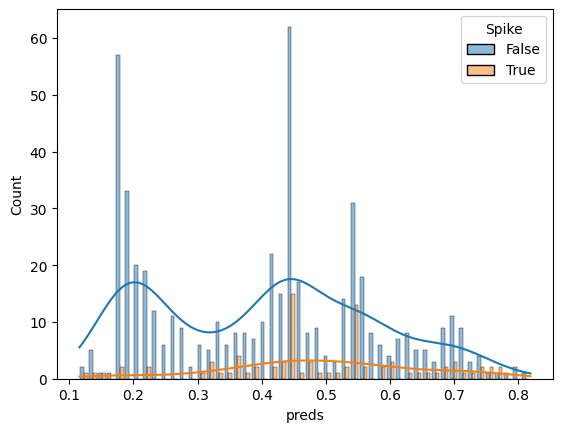

>>>  xgboost (406, 16)
[[172 181]
 [ 15  38]] 

              precision    recall  f1-score   support

       False       0.92      0.49      0.64       353
        True       0.17      0.72      0.28        53

    accuracy                           0.52       406
   macro avg       0.55      0.60      0.46       406
weighted avg       0.82      0.52      0.59       406
 




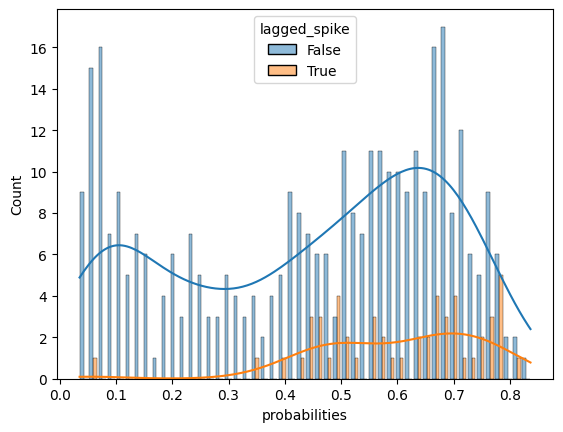

>>>  ffnn (403, 15)
[[240  88]
 [ 44  31]] 

              precision    recall  f1-score   support

       False       0.85      0.73      0.78       328
        True       0.26      0.41      0.32        75

    accuracy                           0.67       403
   macro avg       0.55      0.57      0.55       403
weighted avg       0.74      0.67      0.70       403
 




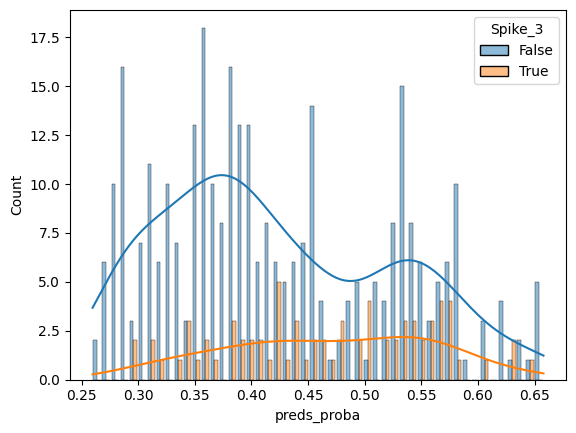

In [78]:
for m, df in dfs.items():
    df['iso3'] = df[meta[m]['fips']].map(fips_iso3_map)
    df = world.merge(df, right_on='iso3', left_on='iso_a3')
    df['yearmonth'] = df['yearmonth'].astype(str)
    bools = ['y_pred', 'y_true']
    for b in bools:
        df[meta[m][b]] = df[meta[m][b]].astype(bool)

    print('>>> ', m, df.shape)
    print(metrics.confusion_matrix(df[meta[m]['y_true']], df[meta[m]['y_pred']]), '\n')
    print(metrics.classification_report(df[meta[m]['y_true']], df[meta[m]['y_pred']]), '\n\n')
    sns.histplot(data=df, x=meta[m]['y_pred_proba'], hue=meta[m]['y_true'], bins=50, kde=True, multiple="dodge", shrink=.8)
    plt.show()
    dfs.update({m: df})

In [79]:
dft = dfs['transformer']
dfx = dfs['xgboost']
dfn = dfs['ffnn']

In [80]:
# create alternate df versions with same columns
_dft = dft.copy().rename(columns={'Code': 'fips', 'class_preds': 'y_pred',
                           'preds': 'y_pred_proba', 'Spike': 'y_true'})
_dft = _dft[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']]

_dfx = dfx.copy().rename(columns={'prediction': 'y_pred',
                           'probabilities': 'y_pred_proba', 'lagged_spike': 'y_true'})
_dfx = _dfx[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']]

_dfn = dfn.copy().rename(columns={'preds': 'y_pred',
                           'preds_proba': 'y_pred_proba', 'Spike_3': 'y_true'})
_dfn = _dfn[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']]

In [81]:
def mutate_alt(df):
    print(df.shape)
    df['iso3'] = df['fips'].map(fips_iso3_map)
    df['yearmonth'] = df['yearmonth'].astype(str)
    df['y_true'] = df['y_true'].astype(bool)
    df = df.set_index(['yearmonth', 'fips'])
    print(df.shape)
    return df

In [82]:
_dft = mutate_alt(_dft)
_dfx = mutate_alt(_dfx)
_dfn = mutate_alt(_dfn)

(615, 6)
(615, 5)
(406, 6)
(406, 5)
(403, 6)
(403, 5)


In [83]:
_dfs = dict(zip(['transformer', 'xgboost', 'ffnn'], [_dft, _dfx, _dfn]))

In [84]:
# join all model predictions
_dfa = _dft.merge(_dfx, left_index=True, right_index=True, suffixes=('_t', '_x'), how="inner")
_dfa = _dfa.merge(_dfn, left_index=True, right_index=True, suffixes=('_a', '_n'), how="inner")

# make an 'ensemble' with mean prediction probabilities
dfe = pd.DataFrame({'y_pred_proba': _dfa[['y_pred_proba_t','y_pred_proba_x', 'y_pred_proba']].mean(axis=1),
                    'y_true': _dfa['y_true_t']})
dfe['y_pred'] = dfe['y_pred_proba'].round().astype(bool)

In [85]:
_dfa.shape

(278, 15)

In [86]:
# each set of predictions has different yearmonths, so many nulls
_dfa = _dfa.dropna(subset=['y_true', 'y_true_t', 'y_true_x'])

In [87]:
common_yearmonths = set.intersection(*[set(df.reset_index()['yearmonth'].unique()) for df in _dfs.values()])
print(common_yearmonths)

{'202212', '202301', '202211'}


In [88]:
_dfa.shape

(278, 15)

In [89]:
_dfa.columns.values

array(['y_pred_t', 'y_pred_proba_t', 'y_true_t', 'model_t', 'iso3_t',
       'y_pred_x', 'y_pred_proba_x', 'y_true_x', 'model_x', 'iso3_x',
       'y_pred', 'y_pred_proba', 'y_true', 'model', 'iso3'], dtype=object)

In [90]:
df_articles = pd.read_csv('datasets_stacked_metadata.csv')
df_articles['yearmonth'] = df_articles['yearmonth'].astype('string')
df_articles = df_articles.rename(columns={'count': 'article_count'})
df_articles = df_articles.drop(columns='filename')

In [91]:
#_dfa.merge(df_articles, left_on=['yearmonth', 'fips'], right_on=['yearmonth', 'country'])

In [92]:
# true values of targets agree for only half of country-yearmonths
#https://stackoverflow.com/questions/22701799/pandas-dataframe-find-rows-where-all-columns-equal#comment99200717_22701944
sum(_dfa[['y_true', 'y_true_t', 'y_true_x']].eq(_dfa[['y_true', 'y_true_t', 'y_true_x']].iloc[:, 0], axis=0).all(axis=1))

196

In [93]:
_dfa[['y_true', 'y_true_t', 'y_true_x']].apply(set, axis=1).apply(len).mean()

1.2949640287769784

In [94]:
_dfa[_dfa['y_true'].ne(_dfa['y_true_t'])][['y_true', 'y_true_t', 'y_true_x']]

Empty DataFrame
Columns: [y_true, y_true_t, y_true_x]
Index: []

In [95]:
_dfa[_dfa['y_true_x'].ne(_dfa['y_true_t'])][['y_true', 'y_true_t', 'y_true_x']]

y_true  y_true_t  y_true_x
yearmonth fips                            
202212    ID     False     False      True
202211    AR      True      True     False
202212    CI     False     False      True
          SO     False     False      True
202211    KE     False     False      True
202212    KE     False     False      True
202301    KE      True      True     False
202212    HA     False     False      True
202211    SF     False     False      True
202212    SF     False     False      True
202301    SF      True      True     False
202211    LT     False     False      True
202301    LT      True      True     False
202211    MX     False     False      True
202301    MX      True      True     False
202212    UY     False     False      True
          BL     False     False      True
202211    PE     False     False      True
202212    PE     False     False      True
202301    PE      True      True     False
202211    NU      True      True     False
          BH     False     False      True
202212    BH      True      True     False
202301    BH      True      True     False
202212    CU     False     False      True
202211    ZI     False     False      True
202301    ZI      True      True     False
202211    WA     False     False      True
202212    ML      True      True     False
          MR     False     False      True
202211    BN      True      True     False
202212    NI      True      True     False
202211    CM     False     False      True
202212    CM     False     False      True
202301    CM      True      True     False
202211    TO      True      True     False
202301    TO     False     False      True
202211    GH      True      True     False
202212    GH      True      True     False
202211    LI      True      True     False
202212    LI      True      True     False
202211    ZA     False     False      True
202301    ZA      True      True     False
202212    MI     False     False      True
202301    MI      True      True     False
202212    AO      True      True     False
202301    AO     False     False      True
202211    LE     False     False      True
202301    LE      True      True     False
202211    AG     False     False      True
202301    AG      True      True     False
202212    JO      True      True     False
202301    JO     False     False      True
202211    TH      True      True     False
202212    IN     False     False      True
202211    NP      True      True     False
          PK     False     False      True
202301    PK      True      True     False
202211    TI     False     False      True
202212    TI     False     False      True
202211    IR      True      True     False
          SY      True      True     False
202212    SY      True      True     False
202211    UP      True      True     False
202212    UP     False     False      True
202211    CE      True      True     False
202212    CE     False     False      True
202211    CH     False     False      True
202301    CH      True      True     False
          AJ     False     False      True
202211    RP      True      True     False
202212    RP     False     False      True
202211    PA      True      True     False
          YM      True      True     False
          SA     False     False      True
202301    SA      True      True     False
202211    MO      True      True     False
          EG      True      True     False
202212    UG      True      True     False
202211    RW     False     False      True
202212    RW      True      True     False
202301    RW      True      True     False

In [96]:
_dfa[_dfa['y_true'].ne(_dfa['y_true_x'])][['y_true', 'y_true_t', 'y_true_x']]

y_true  y_true_t  y_true_x
yearmonth fips                            
202212    ID     False     False      True
202211    AR      True      True     False
202212    CI     False     False      True
          SO     False     False      True
202211    KE     False     False      True
202212    KE     False     False      True
202301    KE      True      True     False
202212    HA     False     False      True
202211    SF     False     False      True
202212    SF     False     False      True
202301    SF      True      True     False
202211    LT     False     False      True
202301    LT      True      True     False
202211    MX     False     False      True
202301    MX      True      True     False
202212    UY     False     False      True
          BL     False     False      True
202211    PE     False     False      True
202212    PE     False     False      True
202301    PE      True      True     False
202211    NU      True      True     False
          BH     False     False      True
202212    BH      True      True     False
202301    BH      True      True     False
202212    CU     False     False      True
202211    ZI     False     False      True
202301    ZI      True      True     False
202211    WA     False     False      True
202212    ML      True      True     False
          MR     False     False      True
202211    BN      True      True     False
202212    NI      True      True     False
202211    CM     False     False      True
202212    CM     False     False      True
202301    CM      True      True     False
202211    TO      True      True     False
202301    TO     False     False      True
202211    GH      True      True     False
202212    GH      True      True     False
202211    LI      True      True     False
202212    LI      True      True     False
202211    ZA     False     False      True
202301    ZA      True      True     False
202212    MI     False     False      True
202301    MI      True      True     False
202212    AO      True      True     False
202301    AO     False     False      True
202211    LE     False     False      True
202301    LE      True      True     False
202211    AG     False     False      True
202301    AG      True      True     False
202212    JO      True      True     False
202301    JO     False     False      True
202211    TH      True      True     False
202212    IN     False     False      True
202211    NP      True      True     False
          PK     False     False      True
202301    PK      True      True     False
202211    TI     False     False      True
202212    TI     False     False      True
202211    IR      True      True     False
          SY      True      True     False
202212    SY      True      True     False
202211    UP      True      True     False
202212    UP     False     False      True
202211    CE      True      True     False
202212    CE     False     False      True
202211    CH     False     False      True
202301    CH      True      True     False
          AJ     False     False      True
202211    RP      True      True     False
202212    RP     False     False      True
202211    PA      True      True     False
          YM      True      True     False
          SA     False     False      True
202301    SA      True      True     False
202211    MO      True      True     False
          EG      True      True     False
202212    UG      True      True     False
202211    RW     False     False      True
202212    RW      True      True     False
202301    RW      True      True     False

In [97]:
preds_by_country = list()
for m, true_col, pred_col in [('ffnn', 'y_true', 'y_pred'),
                              ('transformer', 'y_true_t', 'y_pred_t'),
                              ('xgboost', 'y_true_x', 'y_pred_x')]:
    correct_by_country = (_dfa.groupby('fips')
                          .apply(lambda x: x[true_col].eq(x[pred_col]).sum()))
    incorrect_by_country = (_dfa.groupby('fips')
                            .apply(lambda x: x[true_col].ne(x[pred_col]).sum()))
    
    _dfa_true = _dfa[_dfa[true_col].astype(bool)==True]
    true_correct_by_country = (_dfa_true.groupby('fips')
                            .apply(lambda x: x[true_col].eq(x[pred_col]).sum()))
    true_incorrect_by_country = (_dfa_true.groupby('fips')
                            .apply(lambda x: x[true_col].ne(x[pred_col]).sum()))
    
    _dfa_false = _dfa[_dfa[true_col].astype(bool)==False]
    false_correct_by_country = (_dfa_false.groupby('fips')
                          .apply(lambda x: x[true_col].eq(x[pred_col]).sum()))
    false_incorrect_by_country = (_dfa_false.groupby('fips')
                            .apply(lambda x: x[true_col].ne(x[pred_col]).sum()))
    
    preds_by_country.append(pd.DataFrame({'correct': correct_by_country,
                                          'incorrect': incorrect_by_country,
                                          'correct_true': true_correct_by_country,
                                          'incorrect_true': true_incorrect_by_country,
                                          'correct_false': false_correct_by_country,
                                          'incorrect_false': false_incorrect_by_country,
                                          'model': m}))
df_pc = pd.concat(preds_by_country)
df_pc = df_pc.reset_index()
df_pc['iso3'] = df_pc['fips'].map(fips_iso3_map)
df_pc = world.merge(df_pc, right_on='iso3', left_on='iso_a3')

In [98]:
df_pc

pop_est      continent             name iso_a3  gdp_md_est  \
0      18,513,930.00           Asia       Kazakhstan    KAZ      181665   
1      18,513,930.00           Asia       Kazakhstan    KAZ      181665   
2      18,513,930.00           Asia       Kazakhstan    KAZ      181665   
3     270,625,568.00           Asia        Indonesia    IDN     1119190   
4     270,625,568.00           Asia        Indonesia    IDN     1119190   
5     270,625,568.00           Asia        Indonesia    IDN     1119190   
6      44,938,712.00  South America        Argentina    ARG      445445   
7      44,938,712.00  South America        Argentina    ARG      445445   
8      44,938,712.00  South America        Argentina    ARG      445445   
9      18,952,038.00  South America            Chile    CHL      282318   
10     18,952,038.00  South America            Chile    CHL      282318   
11     18,952,038.00  South America            Chile    CHL      282318   
12     10,192,317.30         Africa          Somalia    SOM        4719   
13     10,192,317.30         Africa          Somalia    SOM        4719   
14     10,192,317.30         Africa          Somalia    SOM        4719   
15     52,573,973.00         Africa            Kenya    KEN       95503   
16     52,573,973.00         Africa            Kenya    KEN       95503   
17     52,573,973.00         Africa            Kenya    KEN       95503   
18     42,813,238.00         Africa            Sudan    SDN       30513   
19     42,813,238.00         Africa            Sudan    SDN       30513   
20     42,813,238.00         Africa            Sudan    SDN       30513   
21     15,946,876.00         Africa             Chad    TCD       11314   
22     15,946,876.00         Africa             Chad    TCD       11314   
23     15,946,876.00         Africa             Chad    TCD       11314   
24     11,263,077.00  North America            Haiti    HTI       14332   
25     11,263,077.00  North America            Haiti    HTI       14332   
26     11,263,077.00  North America            Haiti    HTI       14332   
27     58,558,270.00         Africa     South Africa    ZAF      351431   
28     58,558,270.00         Africa     South Africa    ZAF      351431   
29     58,558,270.00         Africa     South Africa    ZAF      351431   
30      2,125,268.00         Africa          Lesotho    LSO        2376   
31      2,125,268.00         Africa          Lesotho    LSO        2376   
32      2,125,268.00         Africa          Lesotho    LSO        2376   
33    127,575,529.00  North America           Mexico    MEX     1268870   
34    127,575,529.00  North America           Mexico    MEX     1268870   
35    127,575,529.00  North America           Mexico    MEX     1268870   
36      3,461,734.00  South America          Uruguay    URY       56045   
37      3,461,734.00  South America          Uruguay    URY       56045   
38      3,461,734.00  South America          Uruguay    URY       56045   
39    211,049,527.00  South America           Brazil    BRA     1839758   
40    211,049,527.00  South America           Brazil    BRA     1839758   
41    211,049,527.00  South America           Brazil    BRA     1839758   
42     11,513,100.00  South America          Bolivia    BOL       40895   
43     11,513,100.00  South America          Bolivia    BOL       40895   
44     11,513,100.00  South America          Bolivia    BOL       40895   
45     32,510,453.00  South America             Peru    PER      226848   
46     32,510,453.00  South America             Peru    PER      226848   
47     32,510,453.00  South America             Peru    PER      226848   
48     50,339,443.00  South America         Colombia    COL      323615   
49     50,339,443.00  South America         Colombia    COL      323615   
50     50,339,443.00  South America         Colombia    COL      323615   
51      4,246,439.00  North America           Panama    PAN       66800   
52      4,246,439.00  North America   

/opt/homebrew/Caskroom/miniforge/base/envs/magasin/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 3 classes. Setting k to 2.
  warnings.warn(


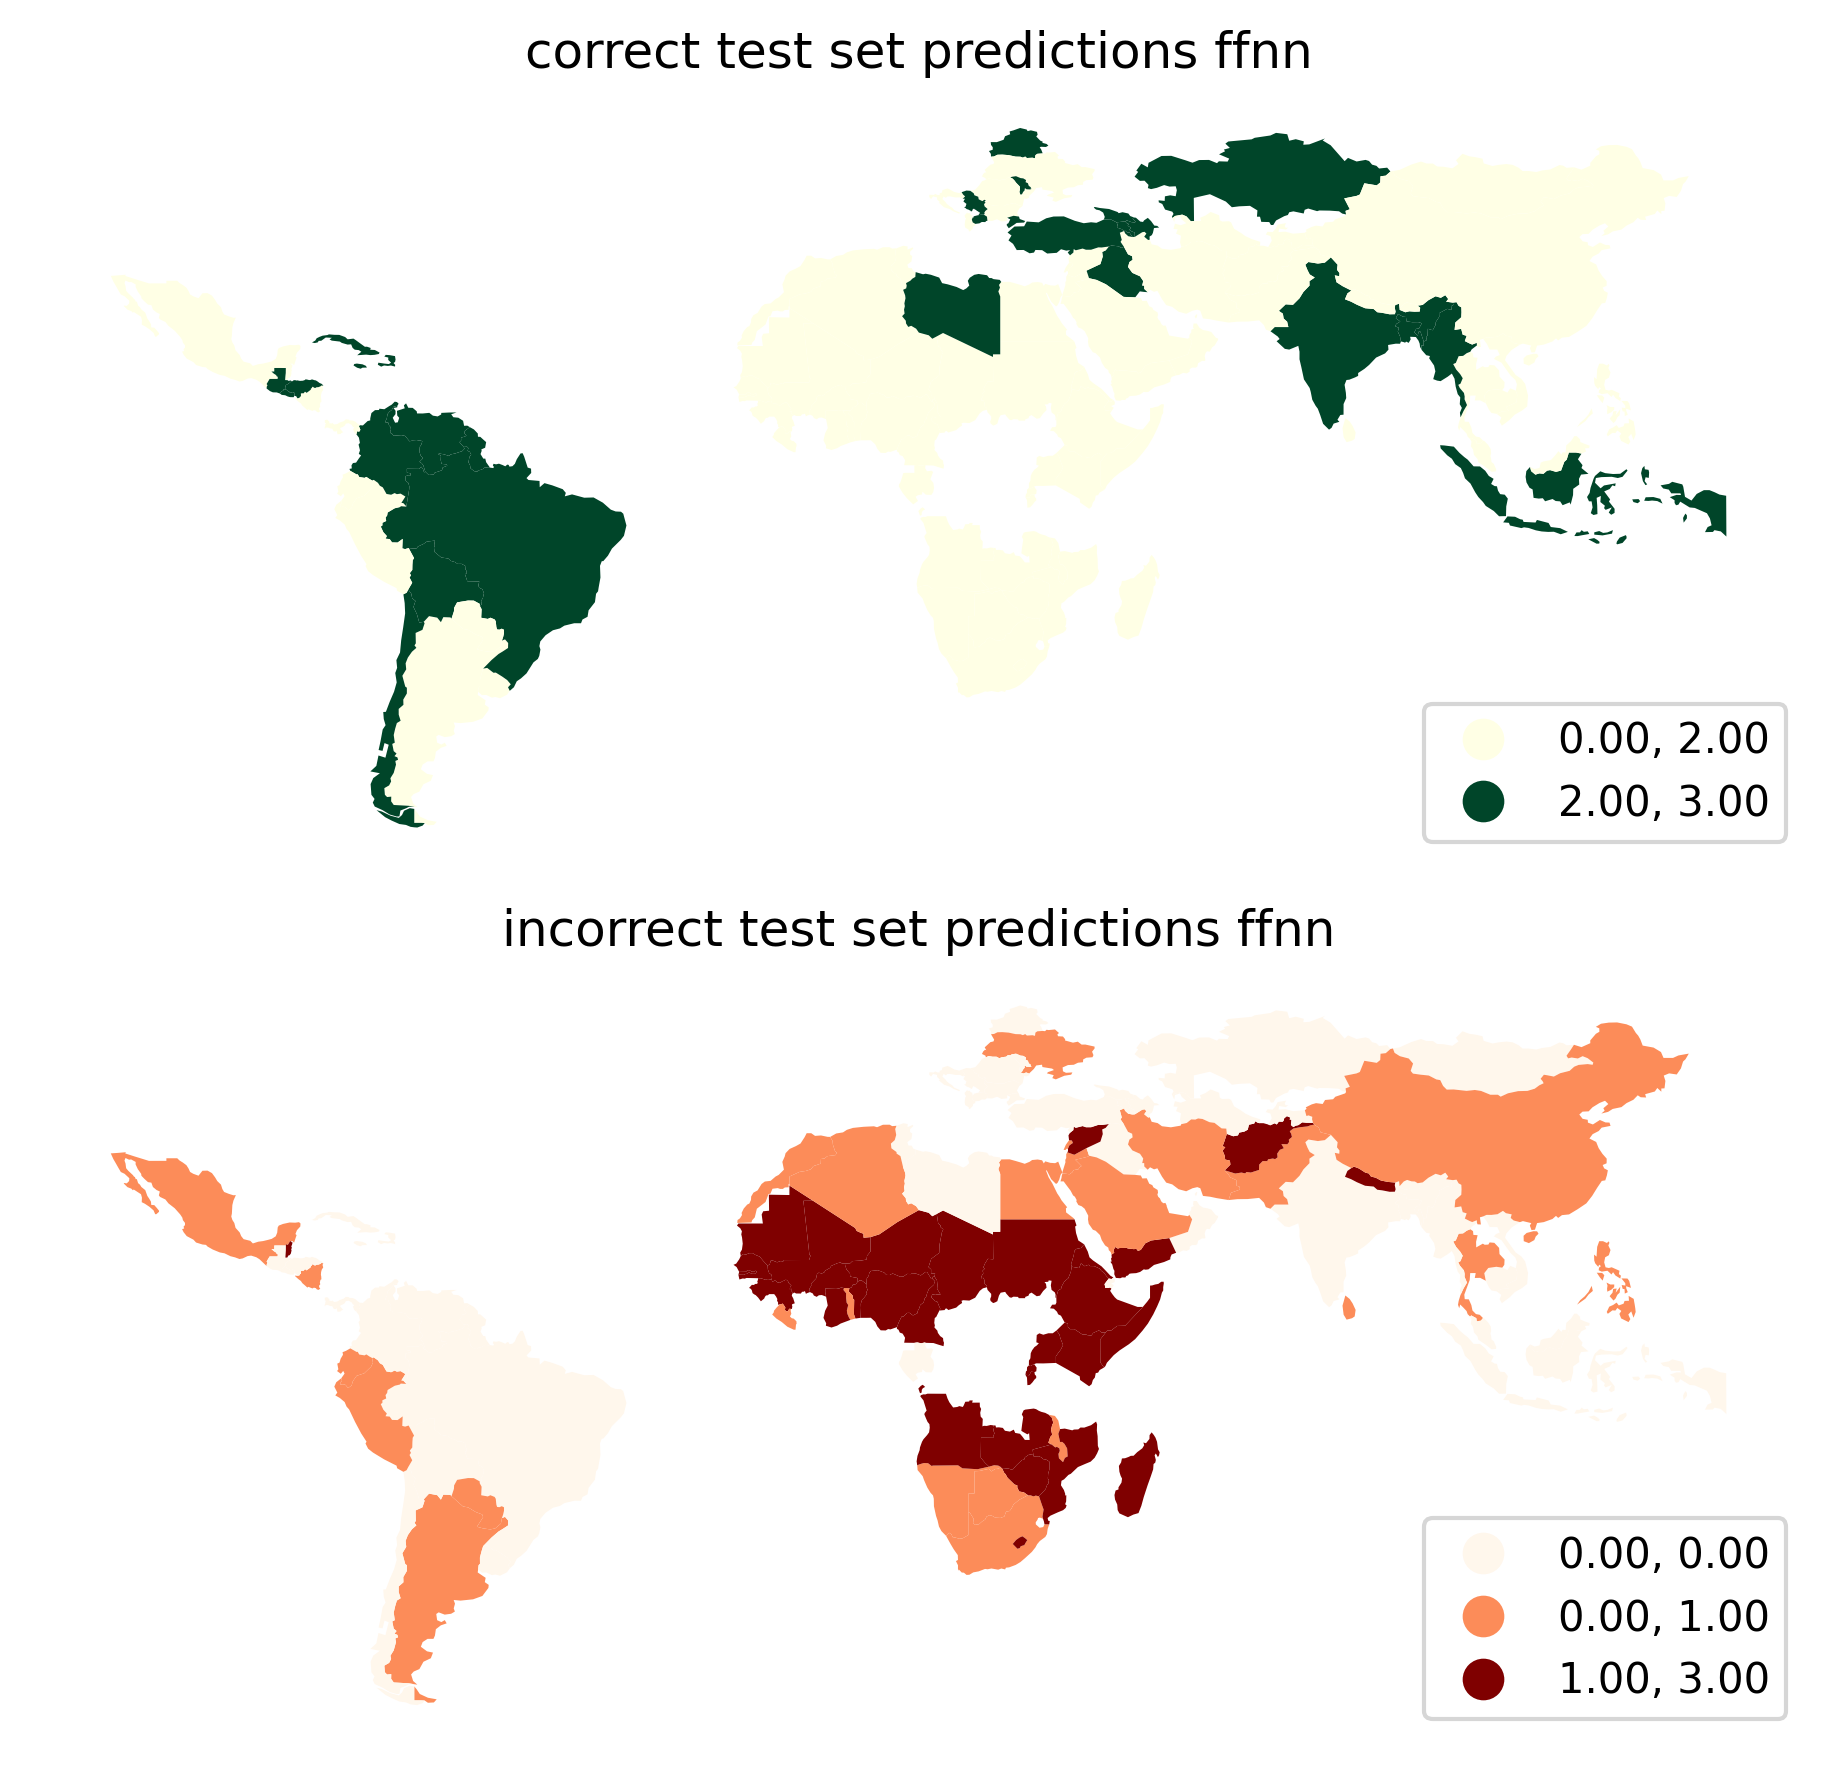

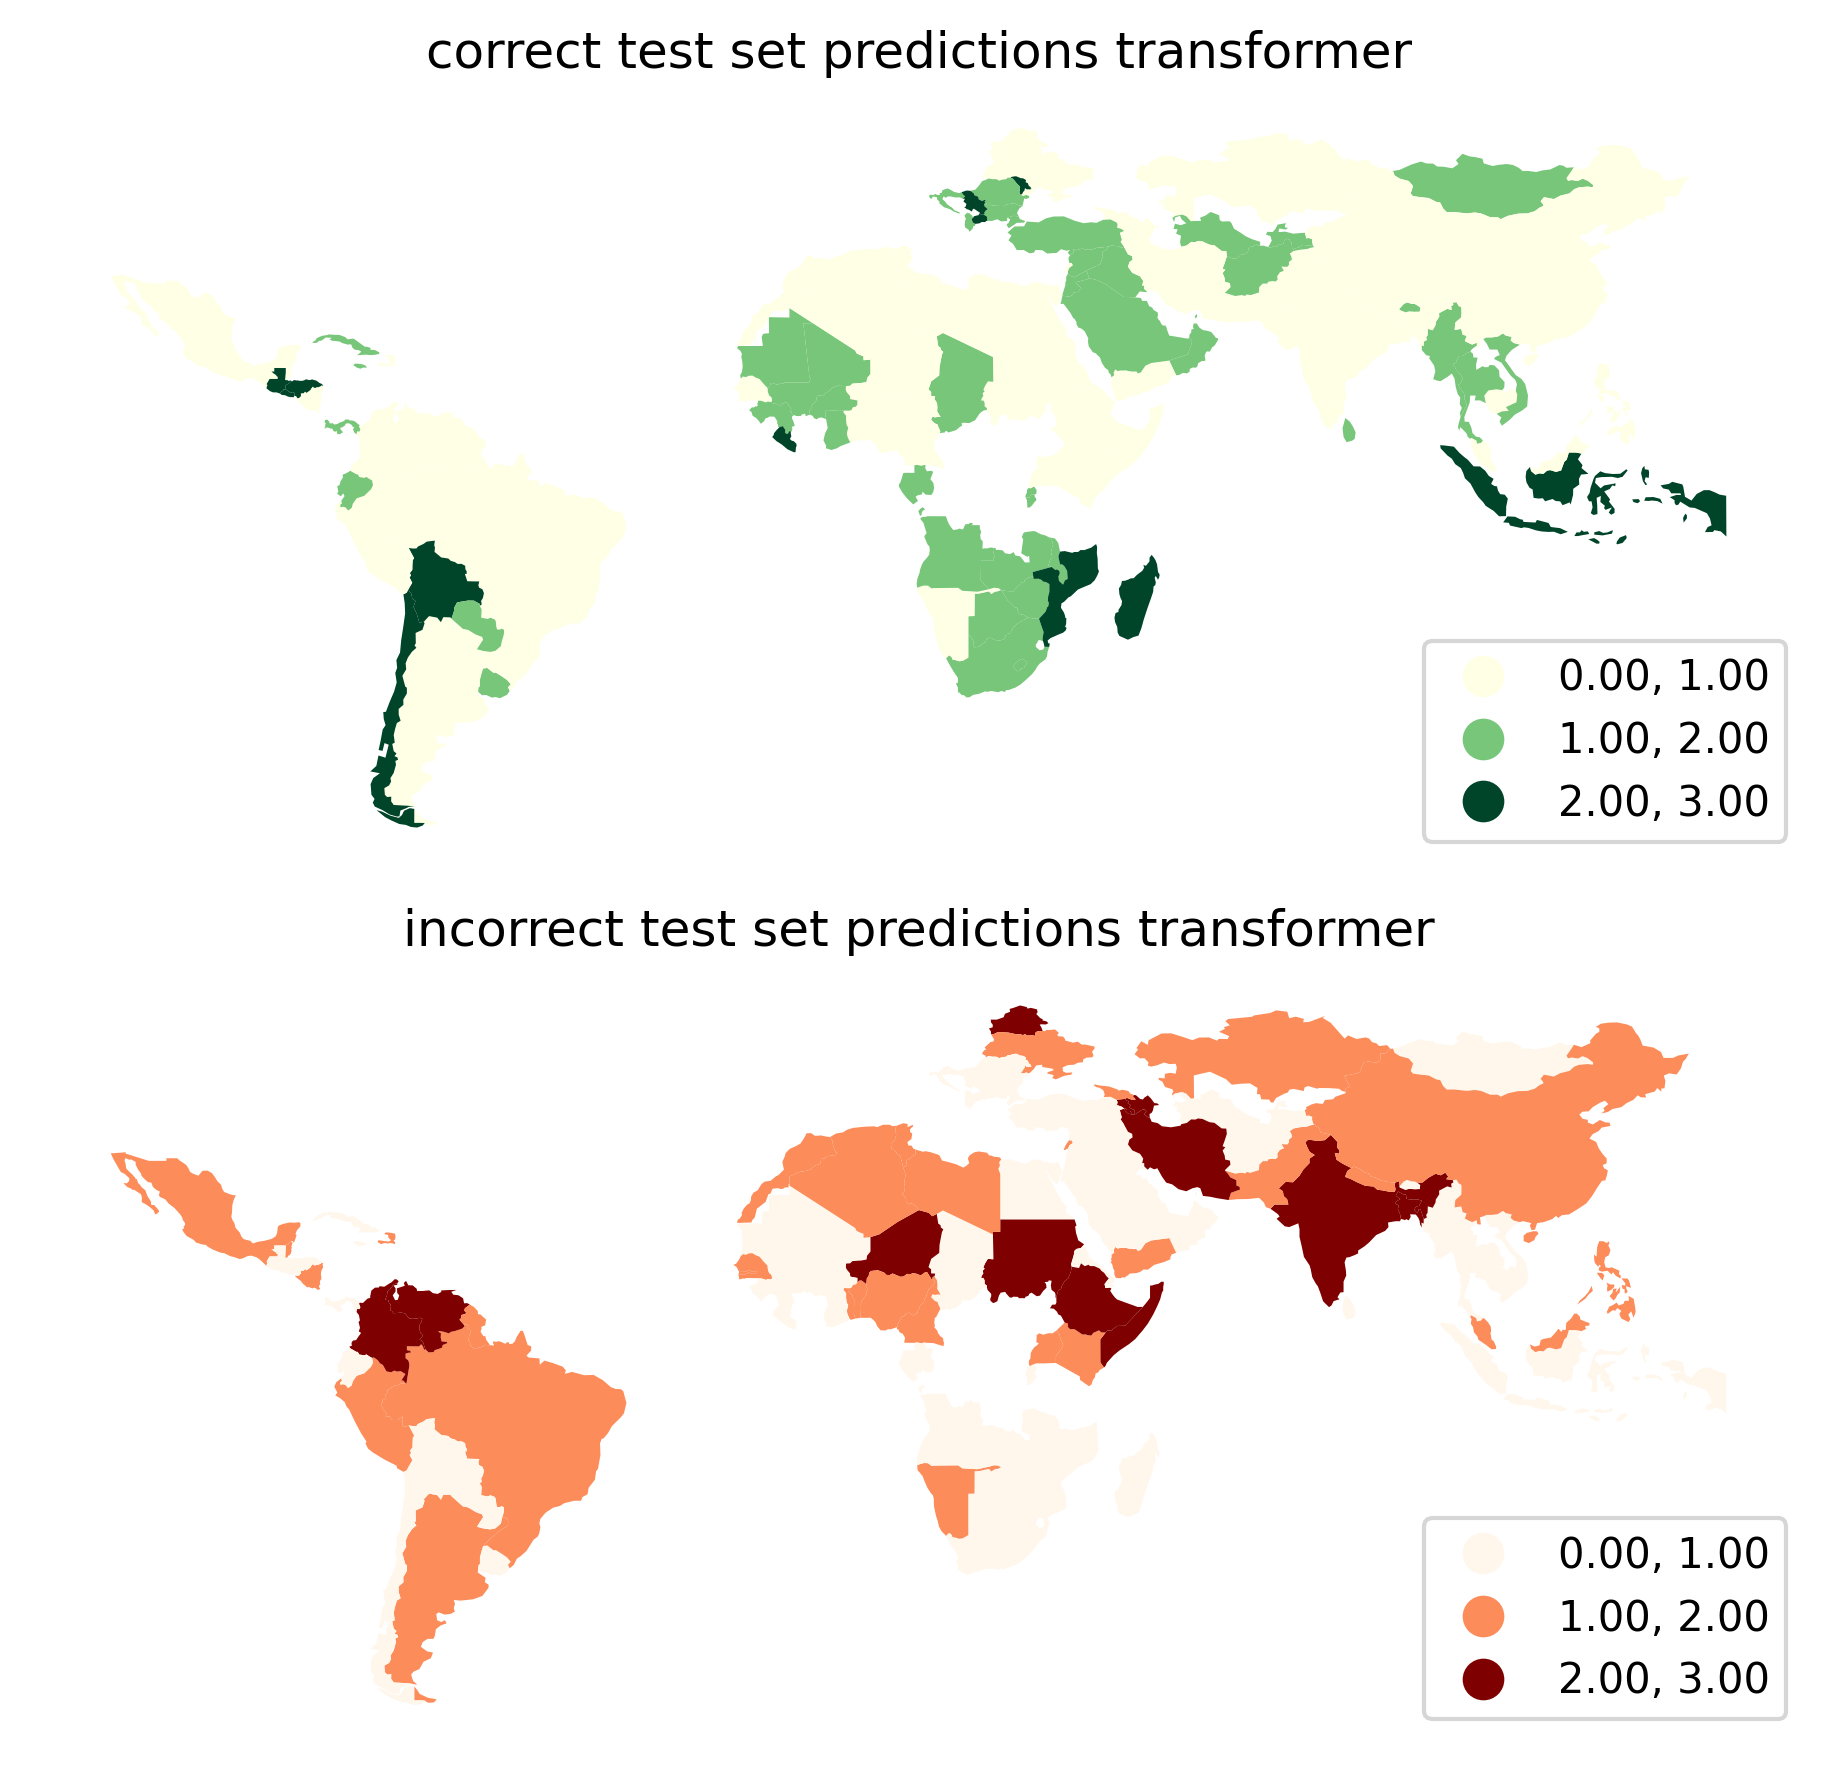

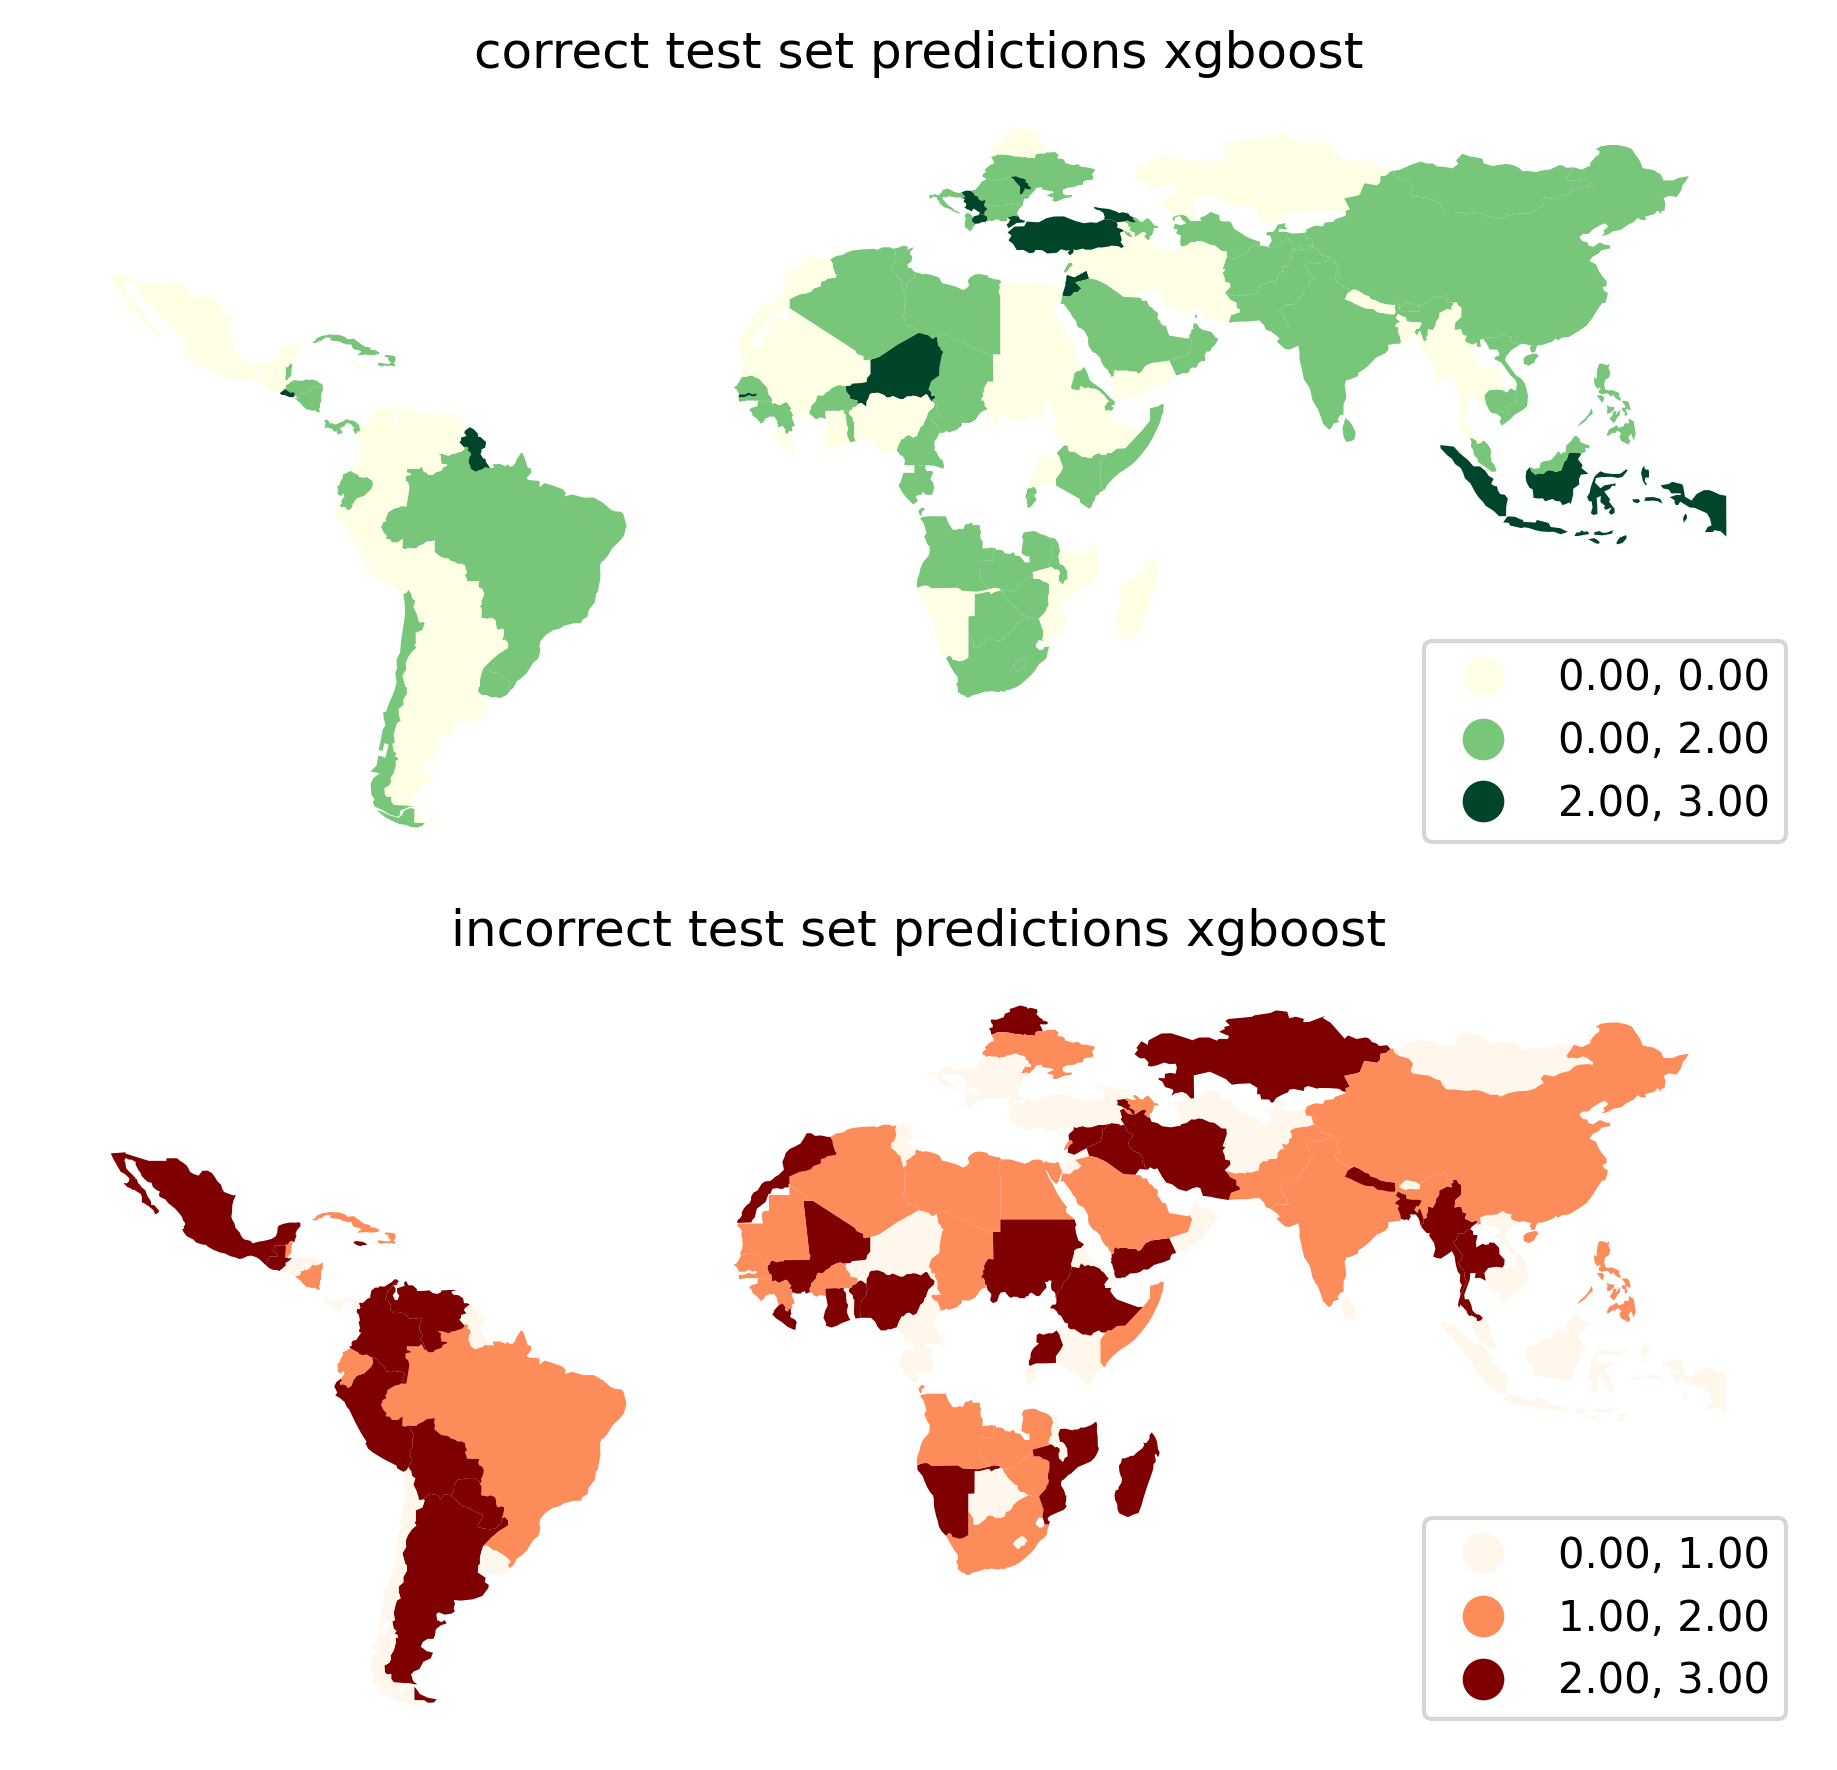

In [136]:
for m, df in df_pc.groupby('model'):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=300)
    axes[0].set_title(f"correct test set predictions {m}")
    df.plot(column='correct', ax=axes[0], scheme='QUANTILES', k=3,
            legend=True, legend_kwds={'loc': 'lower right'}, cmap="YlGn",
            missing_kwds={'color': 'lightgrey'})
    axes[1].set_title(f"incorrect test set predictions {m}")
    df.plot(column='incorrect', ax=axes[1], scheme='QUANTILES', k=3,
            legend=True, legend_kwds={'loc': 'lower right'}, cmap="OrRd",
            missing_kwds={'color': 'lightgrey'})
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    fig.tight_layout()
    plt.savefig(f'imgs/fig-{m}-test-predictions.png')

In [100]:
#df_pc

In [101]:
adf = pd.read_csv(f"gcs://frsght/acled_labels/ACLED_Labels_042823_plus.csv", low_memory=False)[['fips', 'Under-five mortality rate 2019', 'Adolescent population 2020 Proportion of total population (%) Total',
                'High human development', 'Low human development','Medium human development', 'Very high human development',
                'Alert', 'Stable', 'Warning', 'High income', 'Low income', 'Lower middle income', 'Upper middle income']]

In [102]:
def make_country_name_mapper(location_column_name):
    # TODO caller needs a way to find out what `location_column_names` are possible
    # and/or we should match shorthands like
    # {'unicef': 'UNICEFOU', 'iso3': 'ISO3 (geonames)'}
    territory_identifiers = pd.read_csv("gcs://frsght/datasets/country_codes.csv")

    class CountryNameMapper:
        # TODO add docstring
        def __init__(self, location_column_name, codes):
            self.map = dict()
        
            # these columns have country name strings in various formats
            ccode_name_cols = ['Country or Area_en (M49)', 'English Short (unterm)',
                               'English Formal (unterm)', 'name_short (exio-wiod-eora)',
                               'name_official (exio-wiod-eora)', 'Short name (fao)',
                               'Official name (fao)', 'Country (geonames)']

            # make mapping of all various country name formats to desired location_column_name contents
            for country_name_col in ccode_name_cols:
                self.map.update(dict(codes[[country_name_col, location_column_name]].dropna().values))
            print(len(self.map.keys()))
        
        def __call__(self, location_name):
            # TODO would we ever want to return the original location_name
            # rather than empty string when no mapping is found?
            # should make_location_name_mapper take some kind of 'missing value handler' parameter?
            return self.map.get(location_name, '')
        
    return CountryNameMapper(location_column_name, territory_identifiers)

In [103]:
fips_mapper = make_country_name_mapper('fips (geonames)')

638


In [104]:
co = pd.read_csv("/Users/ewheeler/dev/dagster-magasin/files/co-typology.csv")

In [105]:
co.columns.values

array(['Region', 'Business Area', 'Income Group', 'Utilization',
       'Utilization category', 'Cash Transfer', '# IPs', 'Staff',
       'Fragility', 'Emergency', 'Hum - Dev', 'Competitiveness', 'Gender',
       'HDI', 'Population size'], dtype=object)

In [106]:
co['fips'] = co['Business Area'].map(fips_mapper)

In [107]:
_df_pc = df_pc.merge(adf, left_on='fips', right_on='fips', how='inner')

In [108]:
_df_pc = _df_pc.merge(co[['fips', 'Fragility', 'Income Group', 'HDI', 'Region']], left_on='fips', right_on='fips', how='inner')

In [109]:
for col in ['model']:
    one_hot = pd.get_dummies(_df_pc[col].astype('string'))
    one_hot = one_hot.rename(columns=dict([(n, f'{col}-{n}') for n in range(4)]))
    _df_pc = _df_pc.merge(one_hot, left_index=True, right_index=True)

In [110]:
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_rows', 1000)

In [111]:
_name = _df_pc.groupby(['model']).sum(numeric_only=True)[['correct_true', 'incorrect_true', 'correct_false', 'incorrect_false', ]]
_name['ratio_true'] = _name['correct_true'] / (_name['incorrect_true'])
_name['ratio_false'] = _name['correct_false'] / (_name['incorrect_false'])
_name

correct_true  incorrect_true  correct_false  incorrect_false  \
model                                                                       
ffnn             5,454.00        5,013.00      17,730.00        19,797.00   
transformer      6,471.00        3,996.00      18,666.00        18,861.00   
xgboost          6,876.00        1,863.00      10,812.00        28,443.00   

             ratio_true  ratio_false  
model                                 
ffnn               1.09         0.90  
transformer        1.62         0.99  
xgboost            3.69         0.38

HDI


correct  incorrect  correct_true  \
model       HDI                                                             
ffnn        Very high human development     1956        162          0.00   
            High human development          9630       2430          0.00   
transformer Very high human development     1365        753         63.00   
ffnn        Medium human development        6825       4950      1,575.00   
xgboost     Very high human development     1164        954          0.00   
transformer Low human development          11487       9609      2,985.00   
            High human development          6321       5739      1,215.00   
            Medium human development        5964       5811      2,208.00   
xgboost     High human development          5208       6852      1,716.00   
            Low human development           7143      13953      2,268.00   
            Medium human development        3858       7917      2,577.00   
ffnn        Low human development           4773      16323      3,879.00   

                                         incorrect_true  correct_false  \
model       HDI                                                          
ffnn        Very high human development          162.00       1,956.00   
            High human development             2,430.00       9,630.00   
transformer Very high human development           99.00       1,302.00   
ffnn        Medium human development           1,641.00       5,250.00   
xgboost     Very high human development          225.00       1,164.00   
transformer Low human development              1,674.00       8,502.00   
            High human development             1,215.00       5,106.00   
            Medium human development           1,008.00       3,756.00   
xgboost     High human development               693.00       3,492.00   
            Low human development                315.00       4,875.00   
            Medium human development             630.00       1,281.00   
ffnn        Low human development                780.00         894.00   

                                         incorrect_false  ratio  ratio_true  \
model       HDI                                                               
ffnn        Very high human development             0.00  12.07        0.00   
            High human development                  0.00   3.96        0.00   
transformer Very high human development           654.00   1.81        0.64   
ffnn        Medium human development            3,309.00   1.38        0.96   
xgboost     Very high human development           729.00   1.22        0.00   
transformer Low human development               7,935.00   1.20        1.78   
            High human development              4,524.00   1.10        1.00   
            Medium human development            4,803.00   1.03        2.19   
xgboost     High human development              6,159.00   0.76        2.48   
            Low human development              13,638.00   0.51        7.20   
            Medium human development            7,287.00   0.49        4.09   
ffnn        Low human development              15,543.00   0.29        4.97   

                                         ratio_false  
model       HDI                                       
ffnn        Very high human development          inf  
            High human development               inf  
transformer Very high human development         1.99  
ffnn        Medium human development            1.59  
xgboost     Very high human development         1.60  
transformer Low human development               1.07  
            High human development              1.13  
            Medium human development            0.78  
xgboost     High human development              0.57  
            Low human development               0.36  
            Medium human development            0.18  
ffnn        Low human development               0.06

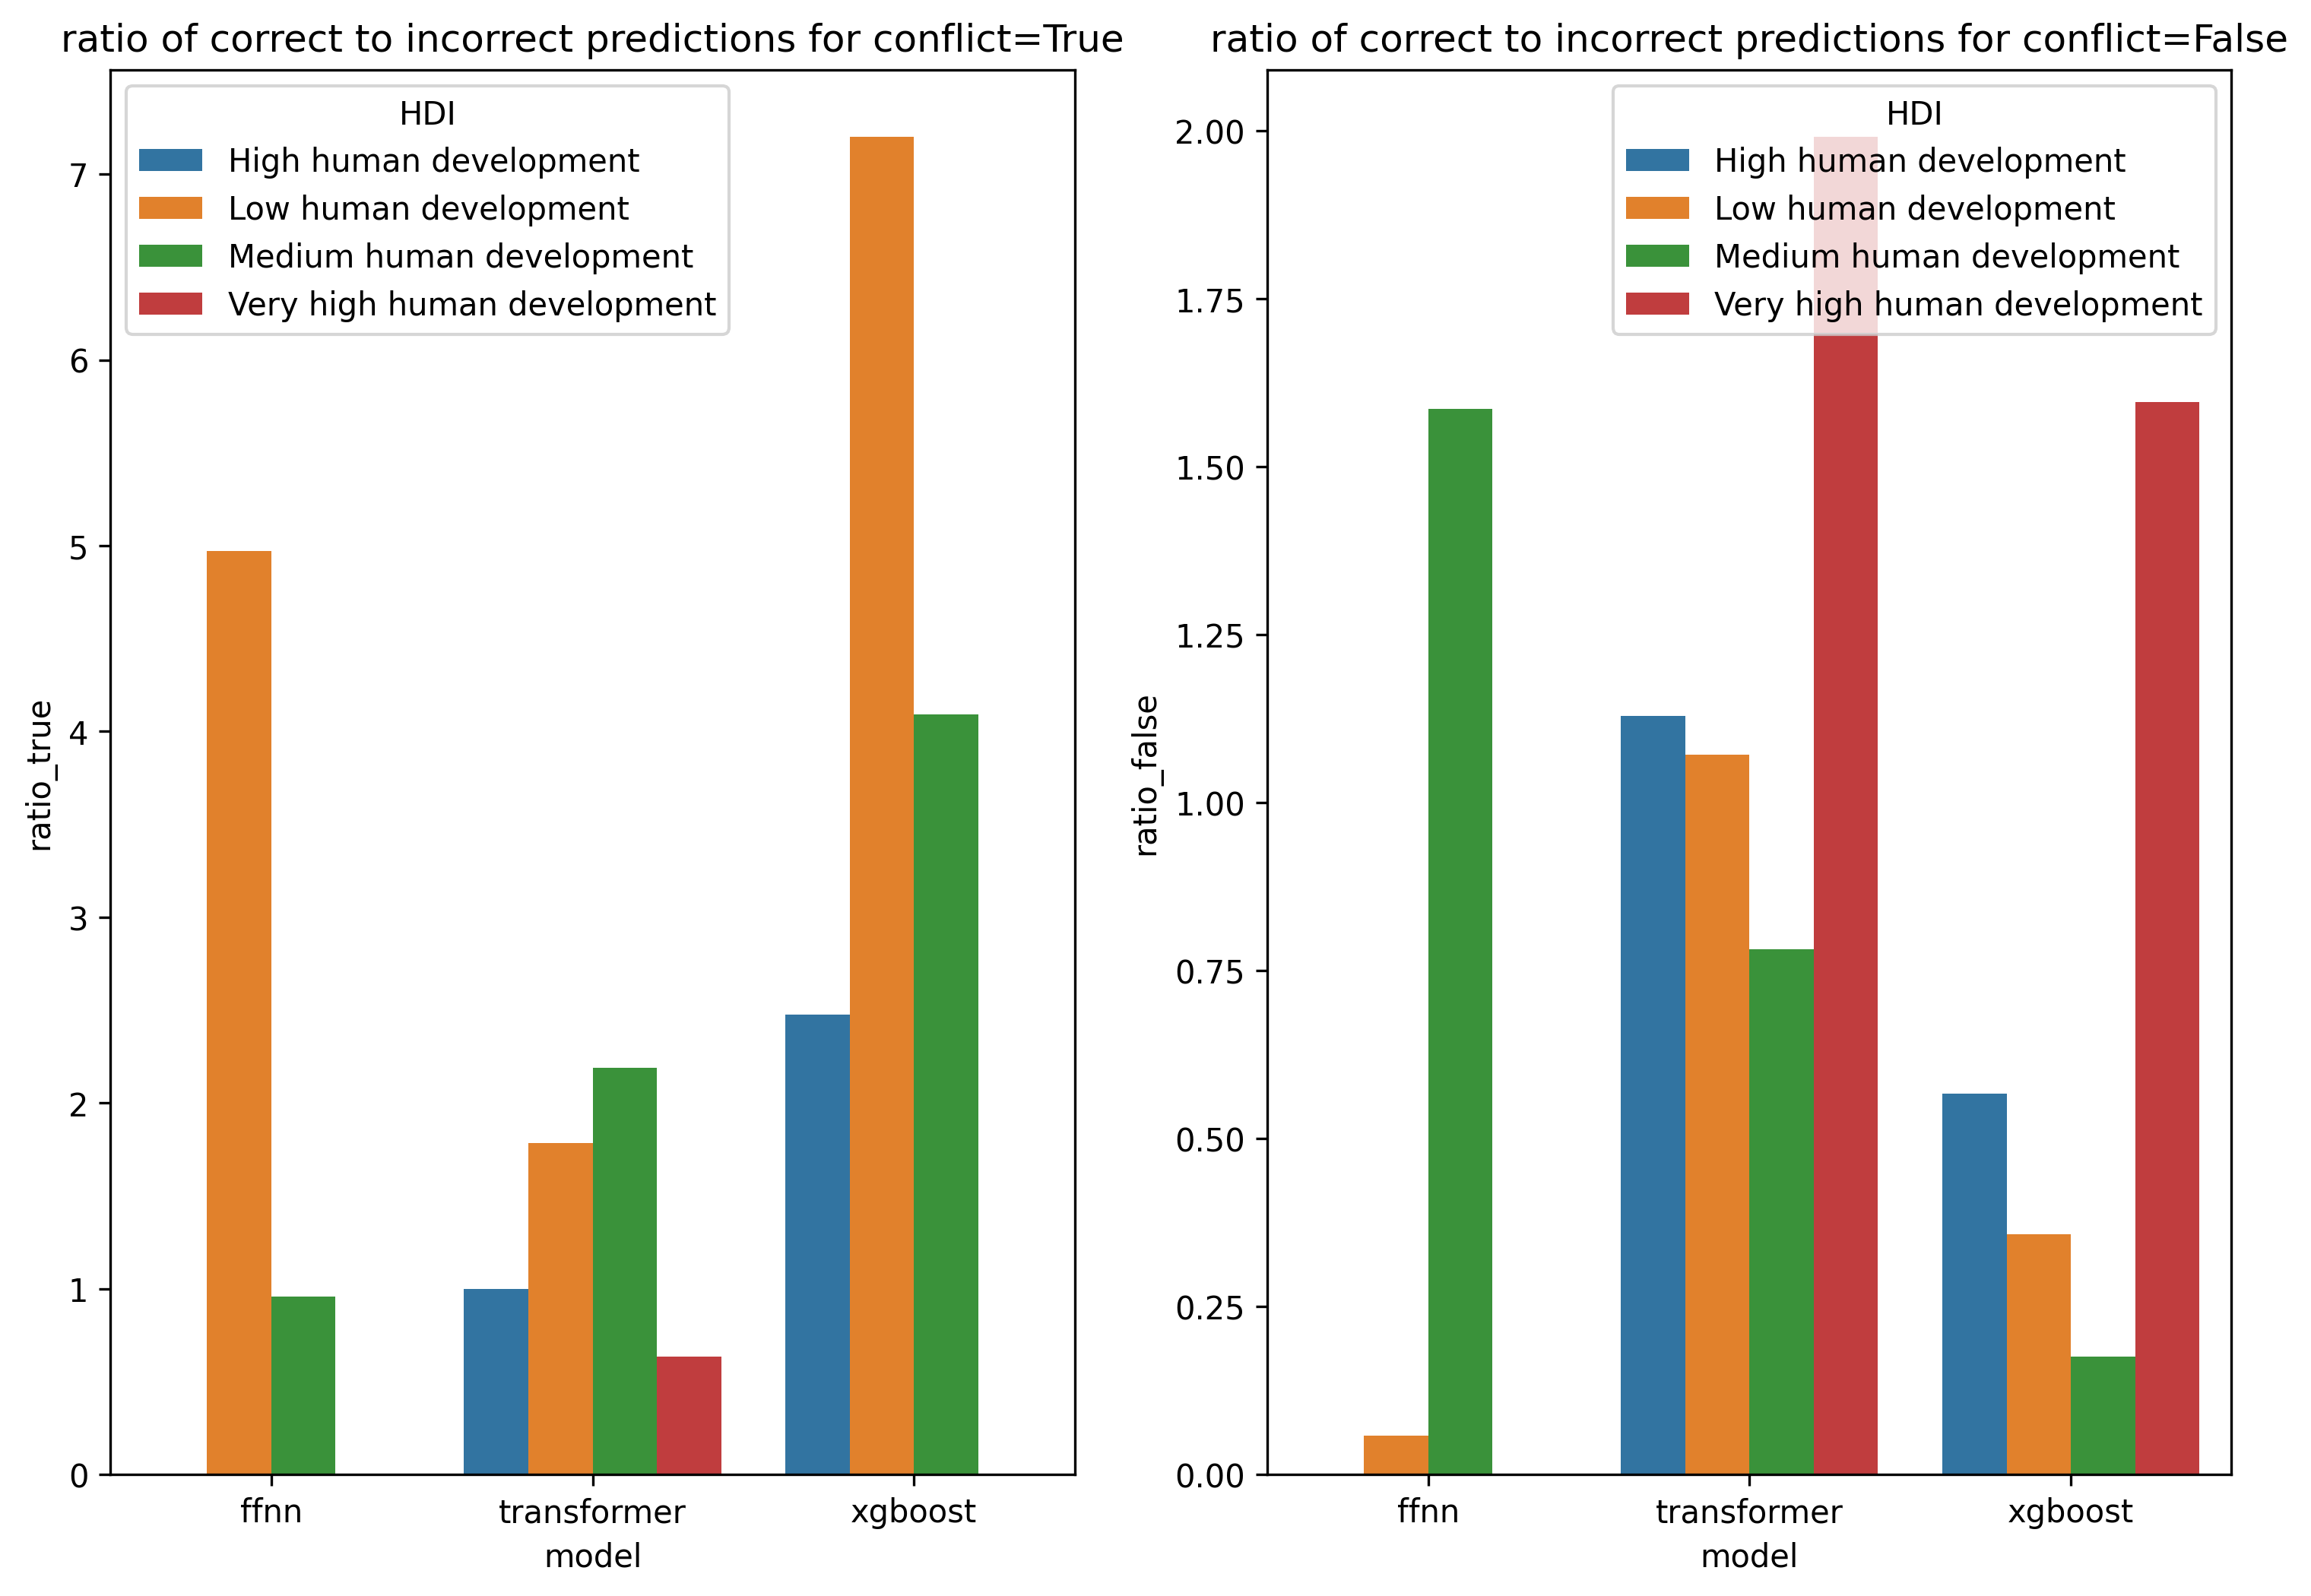

Income Group


correct  incorrect  correct_true  \
model       Income Group                                            
ffnn        High income             1065        162          0.00   
transformer High income             1002        225         63.00   
ffnn        Upper middle income     9237       2121          0.00   
xgboost     High income              714        513          0.00   
transformer Lower middle income     7845       7125      2,514.00   
ffnn        Lower middle income     7824       7146      1,890.00   
transformer Low income             10512       9927      3,144.00   
            Upper middle income     5778       5580        750.00   
xgboost     Upper middle income     4263       7095      1,308.00   
            Lower middle income     5442       9528      2,859.00   
            Low income              7269      13170      2,709.00   
ffnn        Low income              5058      15381      3,564.00   

                                 incorrect_true  correct_false  \
model       Income Group                                         
ffnn        High income                  162.00       1,065.00   
transformer High income                   99.00         939.00   
ffnn        Upper middle income        2,121.00       9,237.00   
xgboost     High income                  225.00         714.00   
transformer Lower middle income        1,167.00       5,331.00   
ffnn        Lower middle income        1,791.00       5,934.00   
transformer Low income                 1,359.00       7,368.00   
            Upper middle income        1,371.00       5,028.00   
xgboost     Upper middle income        1,260.00       2,955.00   
            Lower middle income          378.00       2,583.00   
            Low income                     0.00       4,560.00   
ffnn        Low income                   939.00       1,494.00   

                                 incorrect_false  ratio  ratio_true  \
model       Income Group                                              
ffnn        High income                     0.00   6.57        0.00   
transformer High income                   126.00   4.45        0.64   
ffnn        Upper middle income             0.00   4.36        0.00   
xgboost     High income                   288.00   1.39        0.00   
transformer Lower middle income         5,958.00   1.10        2.15   
ffnn        Lower middle income         5,355.00   1.09        1.06   
transformer Low income                  8,568.00   1.06        2.31   
            Upper middle income         4,209.00   1.04        0.55   
xgboost     Upper middle income         5,835.00   0.60        1.04   
            Lower middle income         9,150.00   0.57        7.56   
            Low income                 13,170.00   0.55         inf   
ffnn        Low income                 14,442.00   0.33        3.80   

                                 ratio_false  
model       Income Group                      
ffnn        High income                  inf  
transformer High income                 7.45  
ffnn        Upper middle income          inf  
xgboost     High income                 2.48  
transformer Lower middle income         0.89  
ffnn        Lower middle income         1.11  
transformer Low income                  0.86  
            Upper middle income         1.19  
xgboost     Upper middle income         0.51  
            Lower middle income         0.28  
            Low income                  0.35  
ffnn        Low income                  0.10

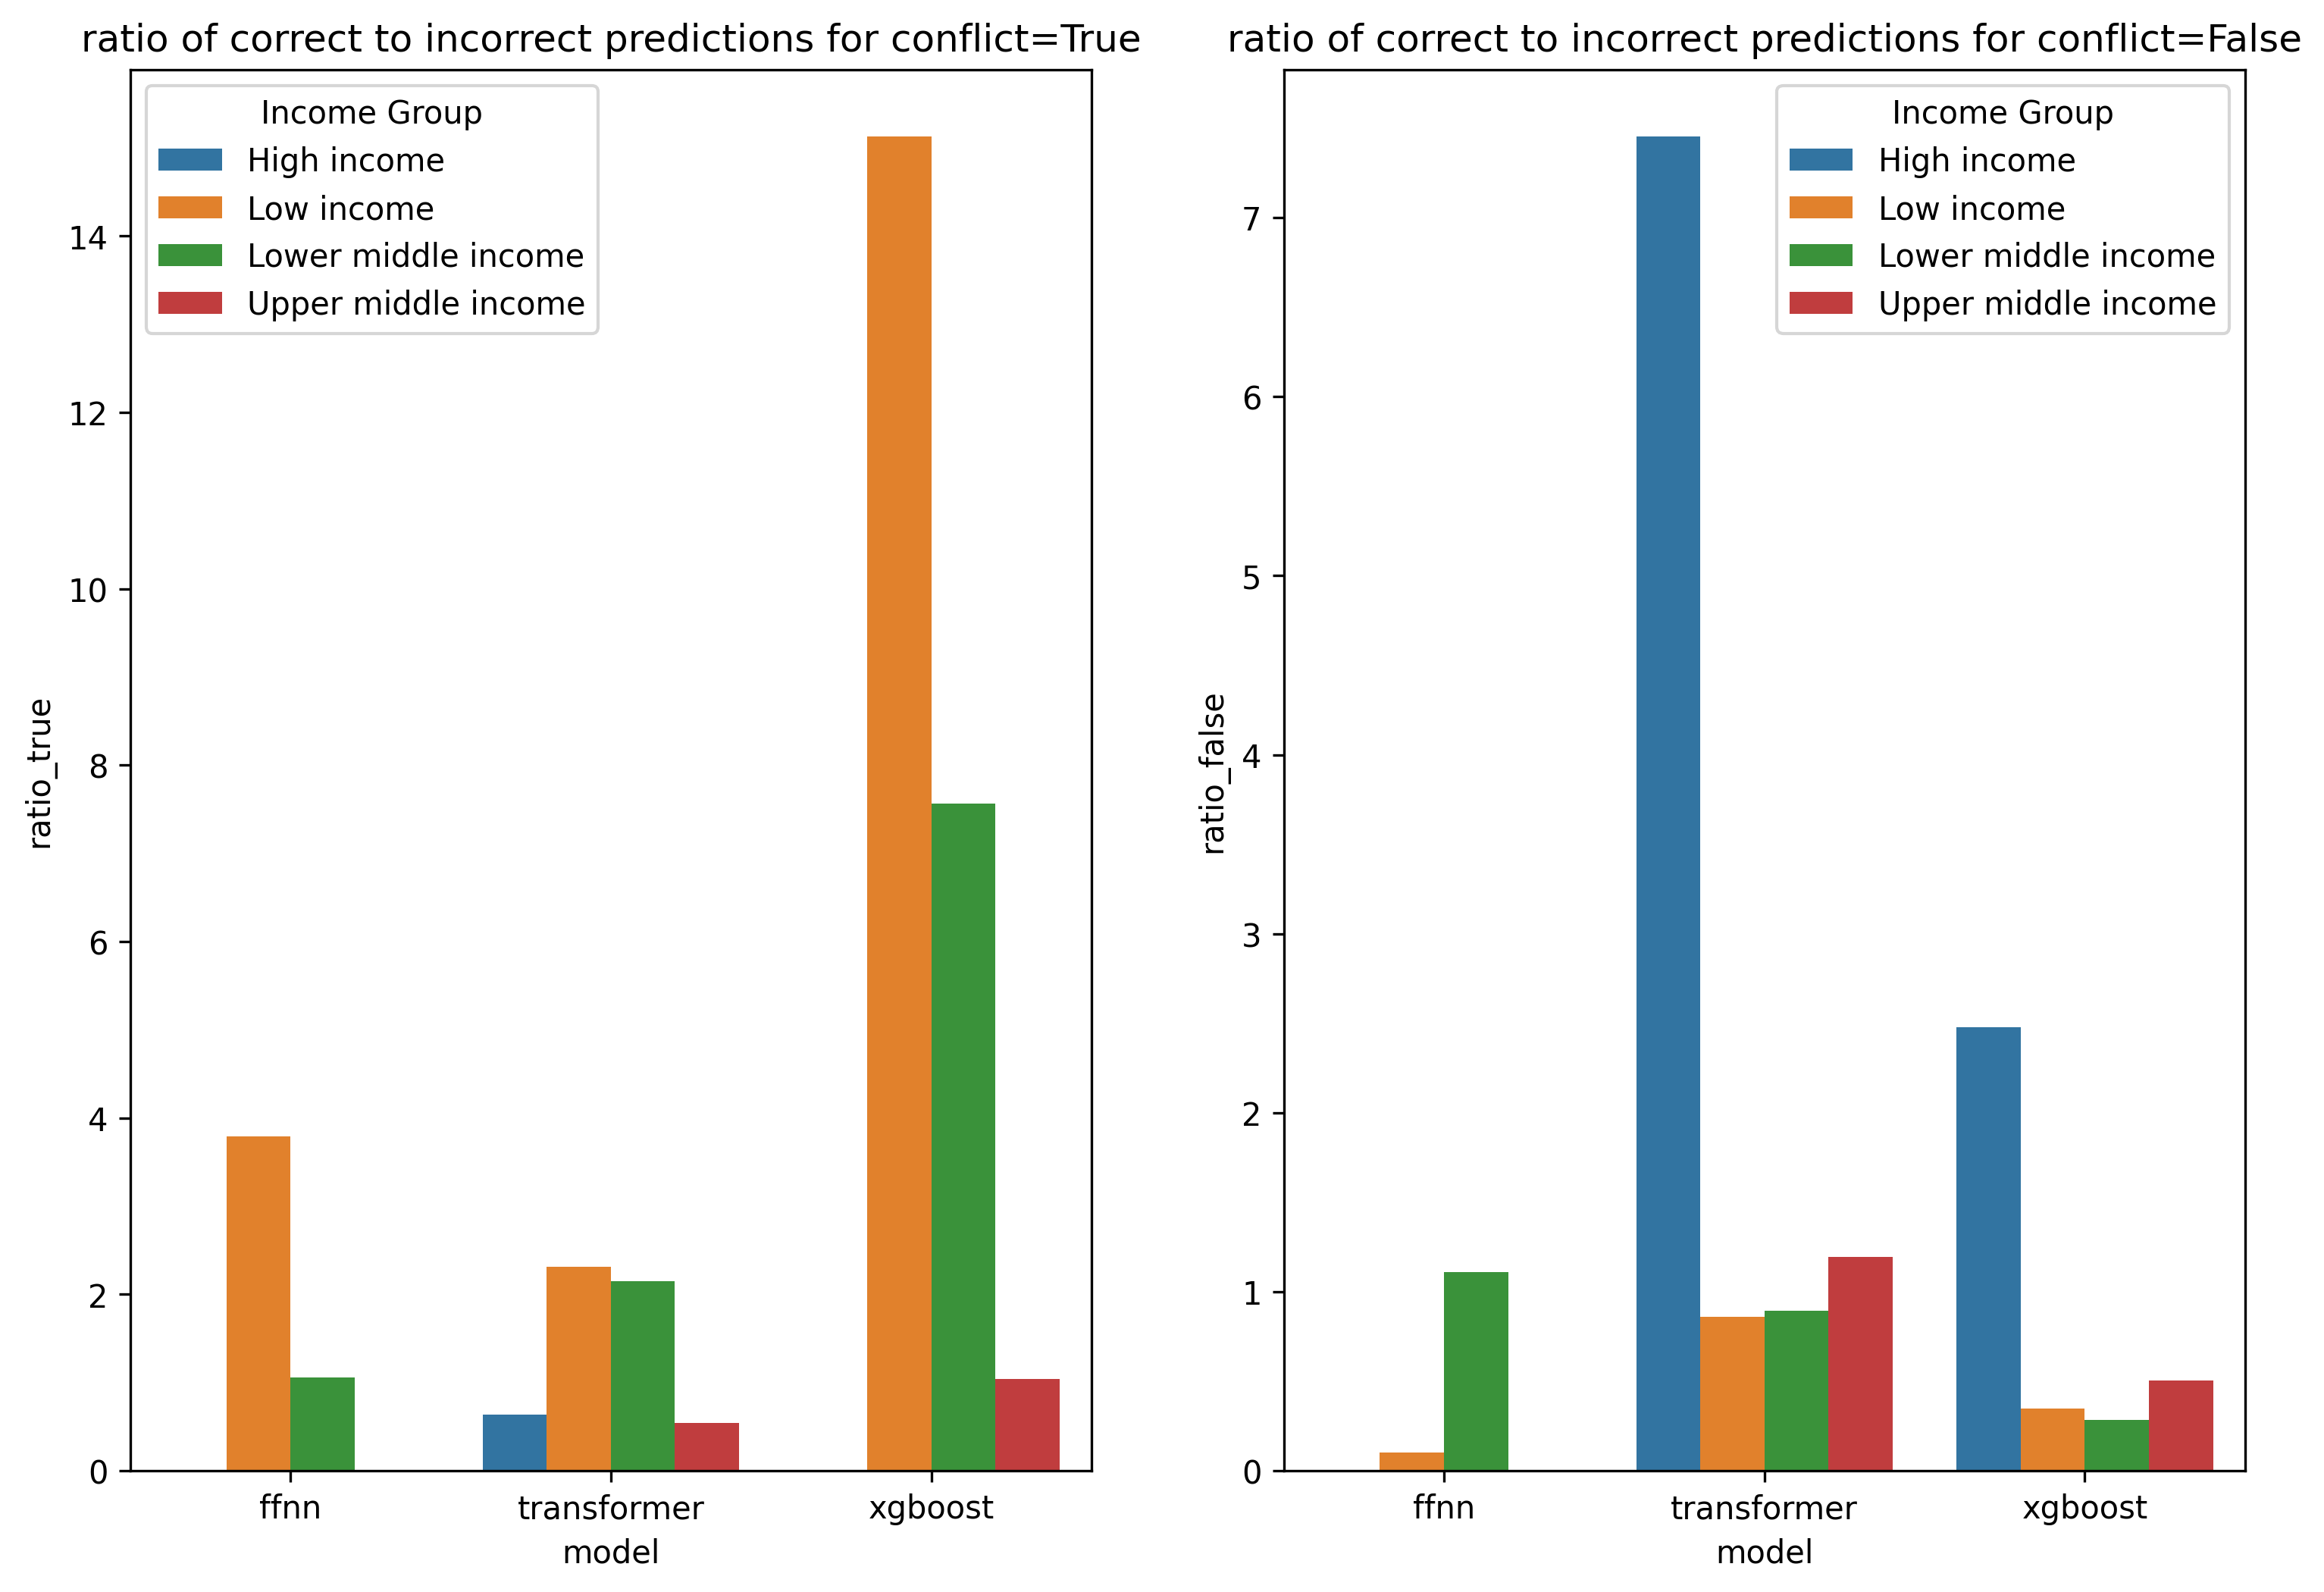

Fragility


correct  incorrect  correct_true  incorrect_true  \
model       Fragility                                                     
ffnn        Stable        2001        378          0.00          378.00   
transformer Stable        1938        441         63.00          315.00   
xgboost     Stable        1749        630        315.00          126.00   
ffnn        Warning      16299      12045      2,835.00        4,326.00   
transformer Warning      15471      12873      3,579.00        3,582.00   
            Alert         7728       9543      2,829.00           99.00   
xgboost     Warning      10842      17502      4,449.00        1,422.00   
            Alert         5097      12174      2,112.00          315.00   
ffnn        Alert         4884      12387      2,619.00          309.00   

                       correct_false  incorrect_false  ratio  ratio_true  \
model       Fragility                                                      
ffnn        Stable          2,001.00             0.00   5.29        0.00   
transformer Stable          1,875.00           126.00   4.39        0.20   
xgboost     Stable          1,434.00           504.00   2.78        2.50   
ffnn        Warning        13,464.00         7,719.00   1.35        0.66   
transformer Warning        11,892.00         9,291.00   1.20        1.00   
            Alert           4,899.00         9,444.00   0.81       28.58   
xgboost     Warning         6,393.00        16,080.00   0.62        3.13   
            Alert           2,985.00        11,859.00   0.42        6.70   
ffnn        Alert           2,265.00        12,078.00   0.39        8.48   

                       ratio_false  
model       Fragility               
ffnn        Stable             inf  
transformer Stable           14.88  
xgboost     Stable            2.85  
ffnn        Warning           1.74  
transformer Warning           1.28  
            Alert             0.52  
xgboost     Warning           0.40  
            Alert             0.25  
ffnn        Alert             0.19

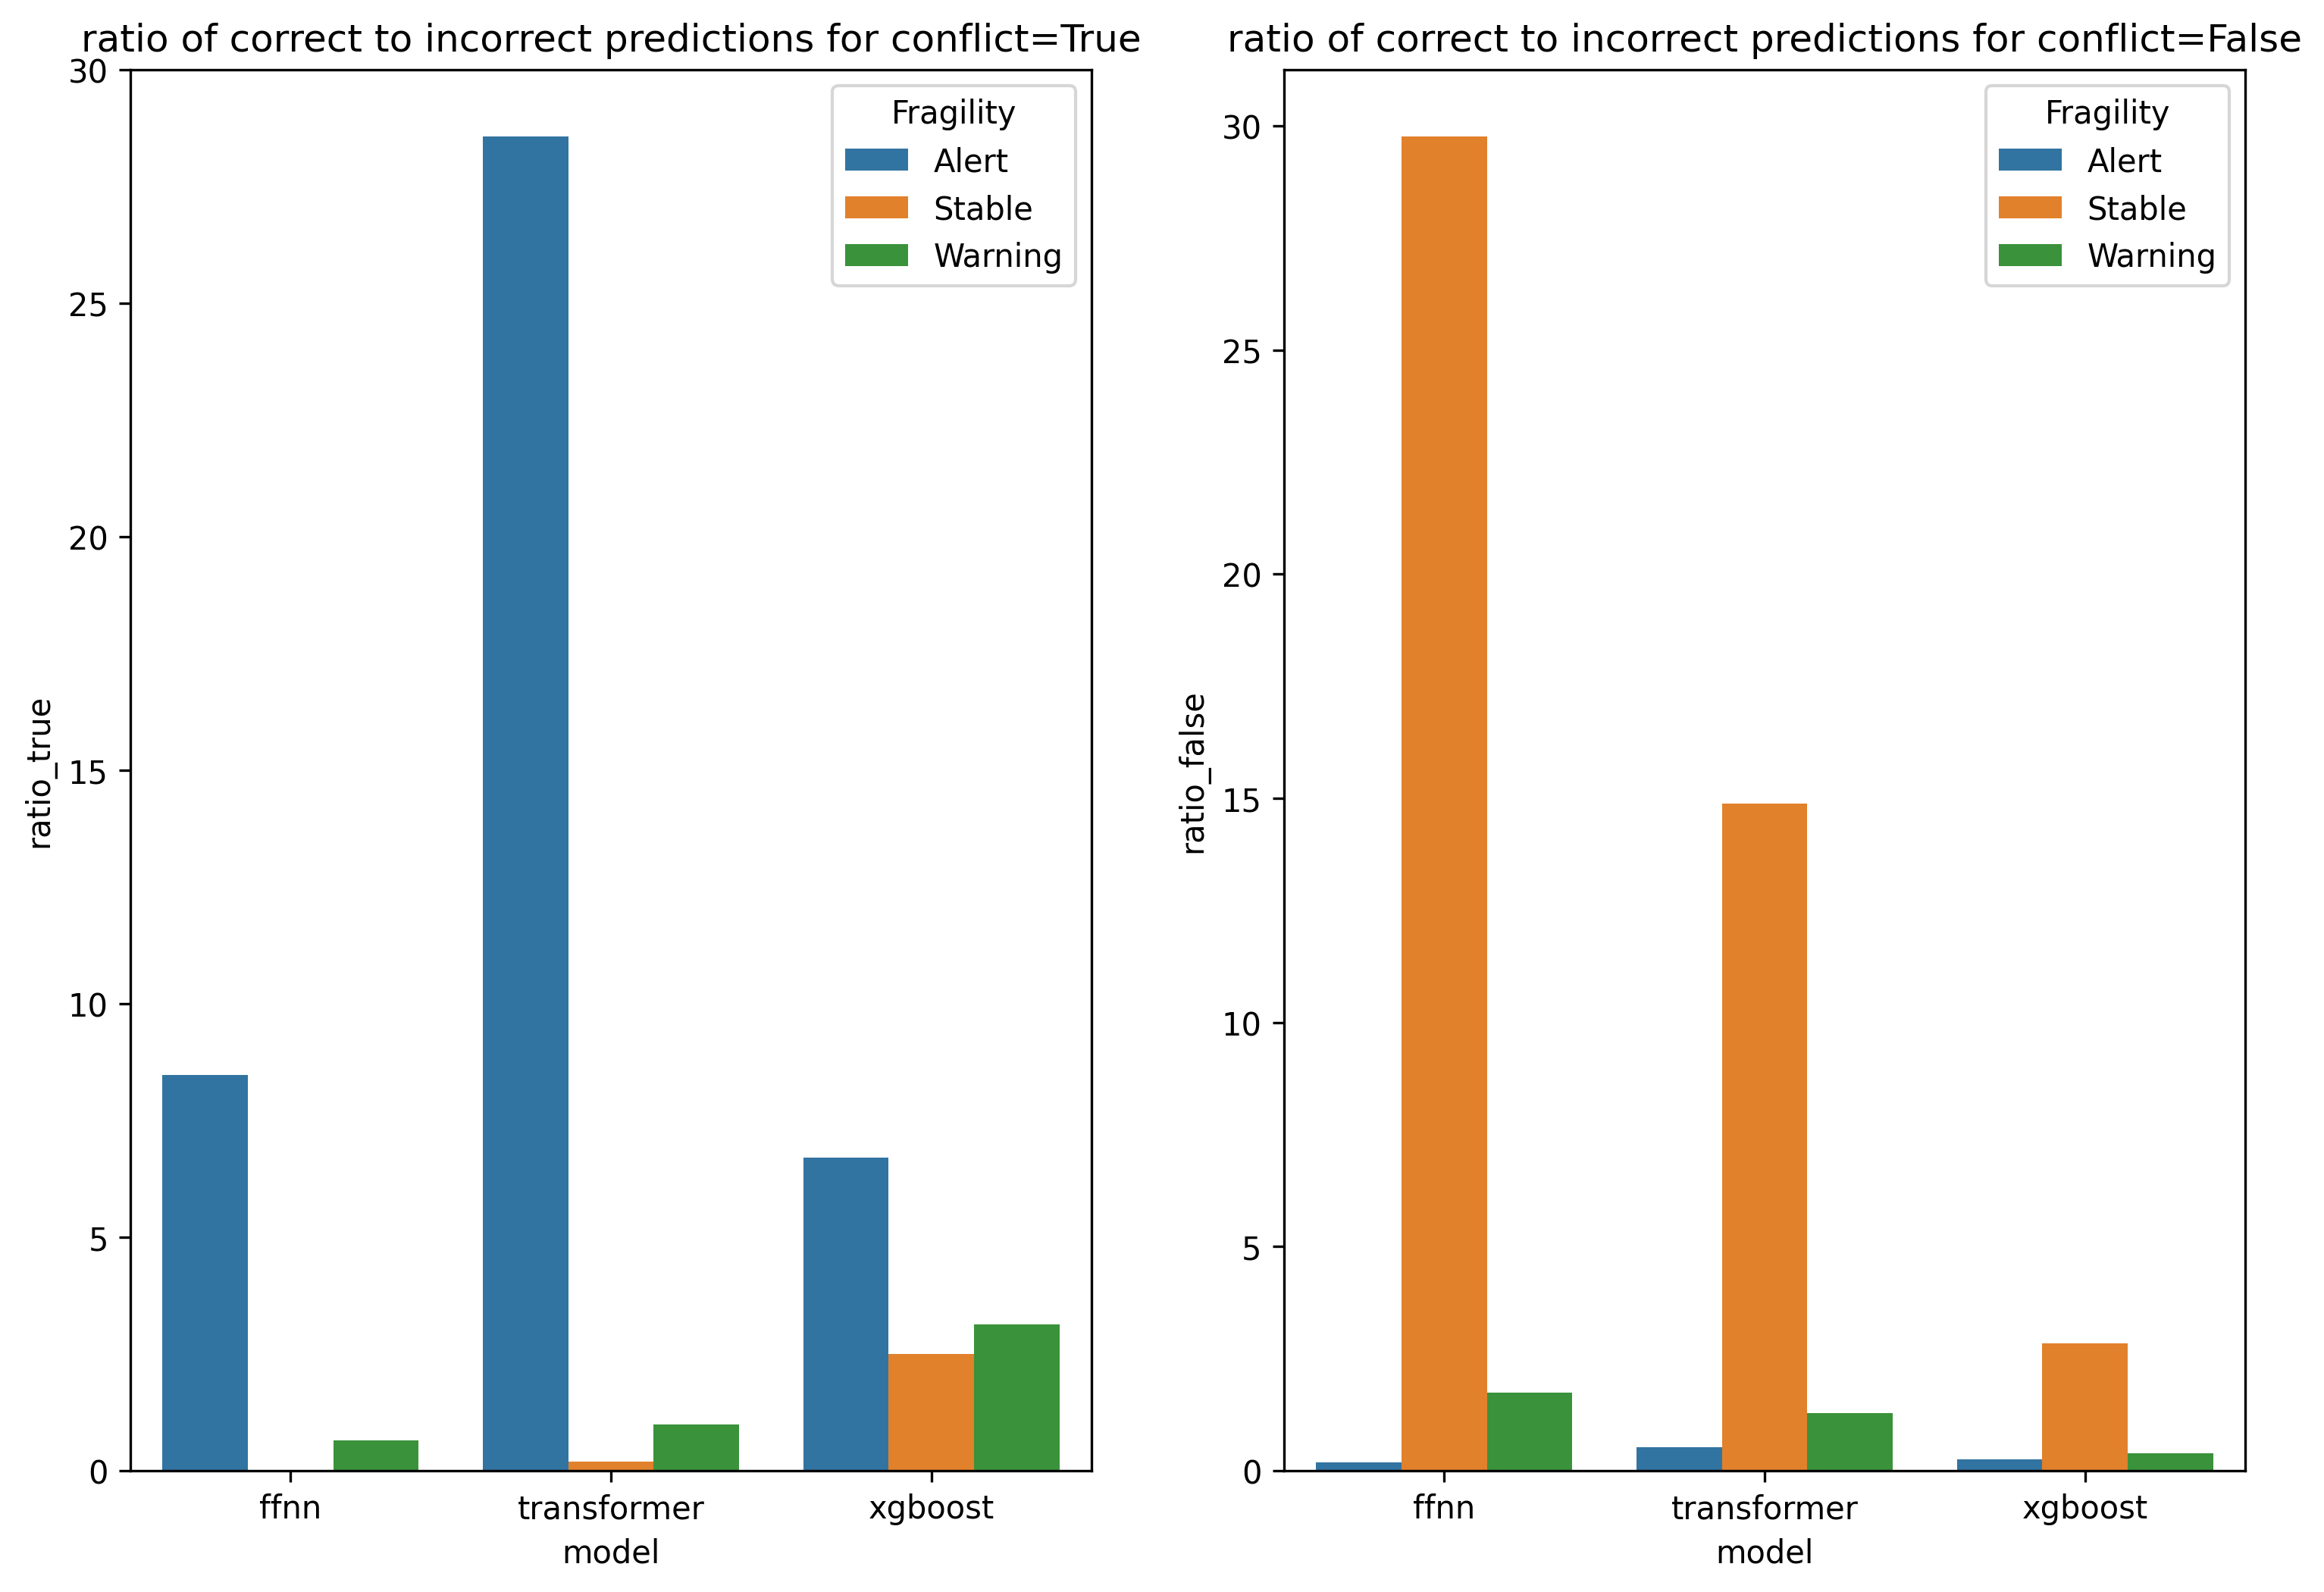

continent


correct  incorrect  correct_true  incorrect_true  \
model       continent                                                         
ffnn        Europe            1386         63          0.00           63.00   
            South America     1764        252          0.00          252.00   
            North America     1575        252          0.00          252.00   
transformer Europe            1134        315         63.00            0.00   
xgboost     Europe            1134        315         63.00            0.00   
ffnn        Asia              6489       1878         99.00        1,296.00   
transformer North America     1197        630         63.00          189.00   
            Africa           17640      16695      5,355.00        3,150.00   
            South America     1008       1008        126.00          126.00   
            Asia              4158       4209        864.00          531.00   
xgboost     Asia              3387       4980      1,017.00           99.00   
            North America      693       1134         63.00          189.00   
ffnn        Africa           11970      22365      5,355.00        3,150.00   
xgboost     Africa           11970      22365      5,670.00        1,260.00   
            South America      504       1512         63.00          315.00   

                           correct_false  incorrect_false  ratio  ratio_true  \
model       continent                                                          
ffnn        Europe              1,386.00             0.00  22.00        0.00   
            South America       1,764.00             0.00   7.00        0.00   
            North America       1,575.00             0.00   6.25        0.00   
transformer Europe              1,071.00           315.00   3.60         inf   
xgboost     Europe              1,071.00           315.00   3.60         inf   
ffnn        Asia                6,390.00           582.00   3.46        0.08   
transformer North America       1,134.00           441.00   1.90        0.33   
            Africa             12,285.00        13,545.00   1.06        1.70   
            South America         882.00           882.00   1.00        1.00   
            Asia                3,294.00         3,678.00   0.99        1.63   
xgboost     Asia                2,370.00         4,881.00   0.68       10.27   
            North America         630.00           945.00   0.61        0.33   
ffnn        Africa              6,615.00        19,215.00   0.54        1.70   
xgboost     Africa              6,300.00        21,105.00   0.54        4.50   
            South America         441.00         1,197.00   0.33        0.20   

                           ratio_false  
model       continent                   
ffnn        Europe                 inf  
            South America          inf  
            North America          inf  
transformer Europe                3.40  
xgboost     Europe                3.40  
ffnn        Asia                 10.98  
transformer North America         2.57  
            Africa                0.91  
            South America         1.00  
            Asia                  0.90  
xgboost     Asia                  0.49  
            North America         0.67  
ffnn        Africa                0.34  
xgboost     Africa                0.30  
            South America         0.37

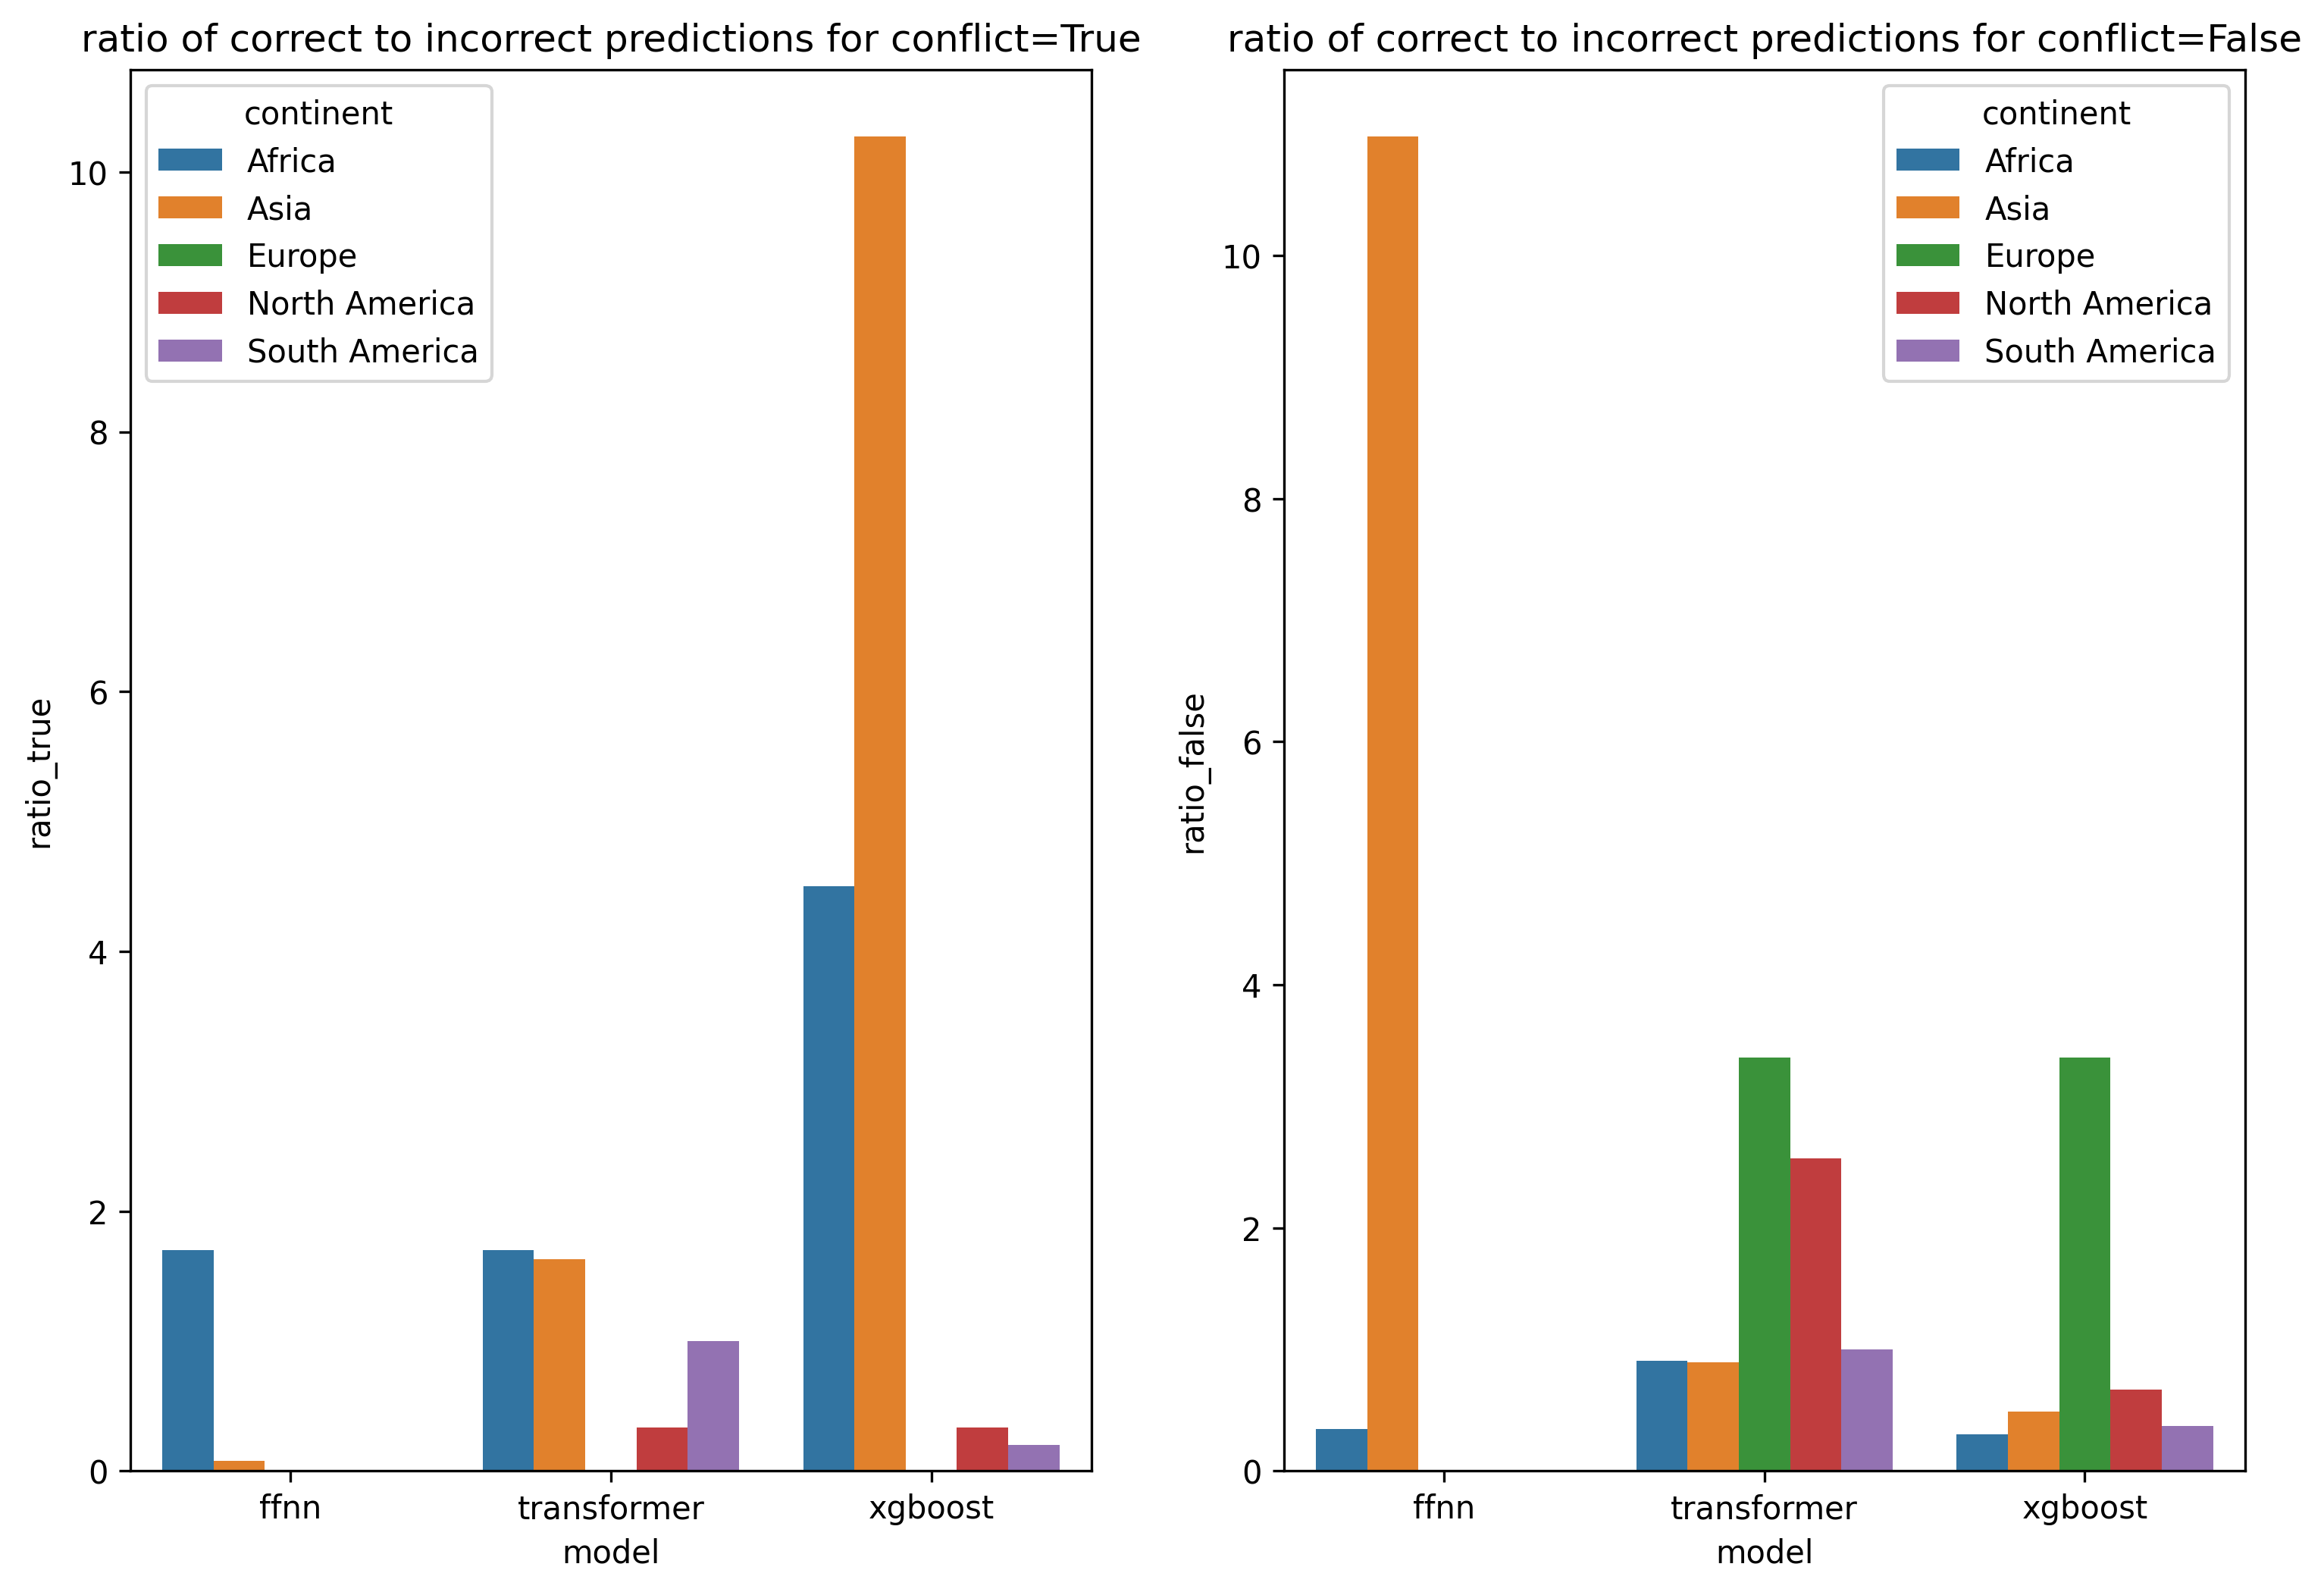

Region


correct  incorrect  correct_true  incorrect_true  \
model       Region                                                     
ffnn        ECAR       2655         63          0.00           63.00   
            EAPR       2280        309          0.00          309.00   
            LACR       3339        504          0.00          504.00   
xgboost     ECAR       1836        882        252.00            0.00   
ffnn        SAR        1611        861          0.00          477.00   
transformer EAPR       1686        903        309.00            0.00   
ffnn        MENAR      4794       2598         99.00        1,455.00   
transformer ECAR       1686       1032         63.00            0.00   
            LACR       2205       1638        189.00          315.00   
            ESAR       8820       6615      2,520.00        1,575.00   
            WCAR       7245       6300      2,205.00        1,260.00   
xgboost     EAPR       1272       1317        249.00            0.00   
            WCAR       5040       8505      1,575.00          315.00   
            ESAR       5670       9765      3,780.00          945.00   
transformer MENAR      2631       4761        867.00          687.00   
            SAR         864       1608        318.00          159.00   
xgboost     SAR         792       1680        405.00            0.00   
            LACR       1197       2646        126.00          504.00   
ffnn        ESAR       4725      10710      2,520.00        1,575.00   
            WCAR       3780       9765      2,835.00          630.00   
xgboost     MENAR      1881       5511        489.00           99.00   

                    correct_false  incorrect_false  ratio  ratio_true  \
model       Region                                                      
ffnn        ECAR         2,655.00             0.00  42.14        0.00   
            EAPR         2,280.00             0.00   7.38        0.00   
            LACR         3,339.00             0.00   6.62        0.00   
xgboost     ECAR         1,584.00           882.00   2.08         inf   
ffnn        SAR          1,611.00           384.00   1.87        0.00   
transformer EAPR         1,377.00           903.00   1.87         inf   
ffnn        MENAR        4,695.00         1,143.00   1.85        0.07   
transformer ECAR         1,623.00         1,032.00   1.63         inf   
            LACR         2,016.00         1,323.00   1.35        0.60   
            ESAR         6,300.00         5,040.00   1.33        1.60   
            WCAR         5,040.00         5,040.00   1.15        1.75   
xgboost     EAPR         1,023.00         1,317.00   0.97         inf   
            WCAR         3,465.00         8,190.00   0.59        5.00   
            ESAR         1,890.00         8,820.00   0.58        4.00   
transformer MENAR        1,764.00         4,074.00   0.55        1.26   
            SAR            546.00         1,449.00   0.54        2.00   
xgboost     SAR            387.00         1,680.00   0.47         inf   
            LACR         1,071.00         2,142.00   0.45        0.25   
ffnn        ESAR         2,205.00         9,135.00   0.44        1.60   
            WCAR           945.00         9,135.00   0.39        4.50   
xgboost     MENAR        1,392.00         5,412.00   0.34        4.94   

                    ratio_false  
model       Region               
ffnn        ECAR            inf  
            EAPR            inf  
            LACR            inf  
xgboost     ECAR           1.80  
ffnn        SAR            4.20  
transformer EAPR           1.52  
ffnn        MENAR          4.11  
transformer ECAR           1.57  
            LACR           1.52  
            ESAR           1.25  
            WCAR           1.00  
xgboost     EAPR           0.78  
            WCAR           0.42  
            ESAR           0.21  
transformer MENAR          0.43  
            SAR            0.38  
xgboost     SAR            0.23  
            LACR           0.50  
ffn

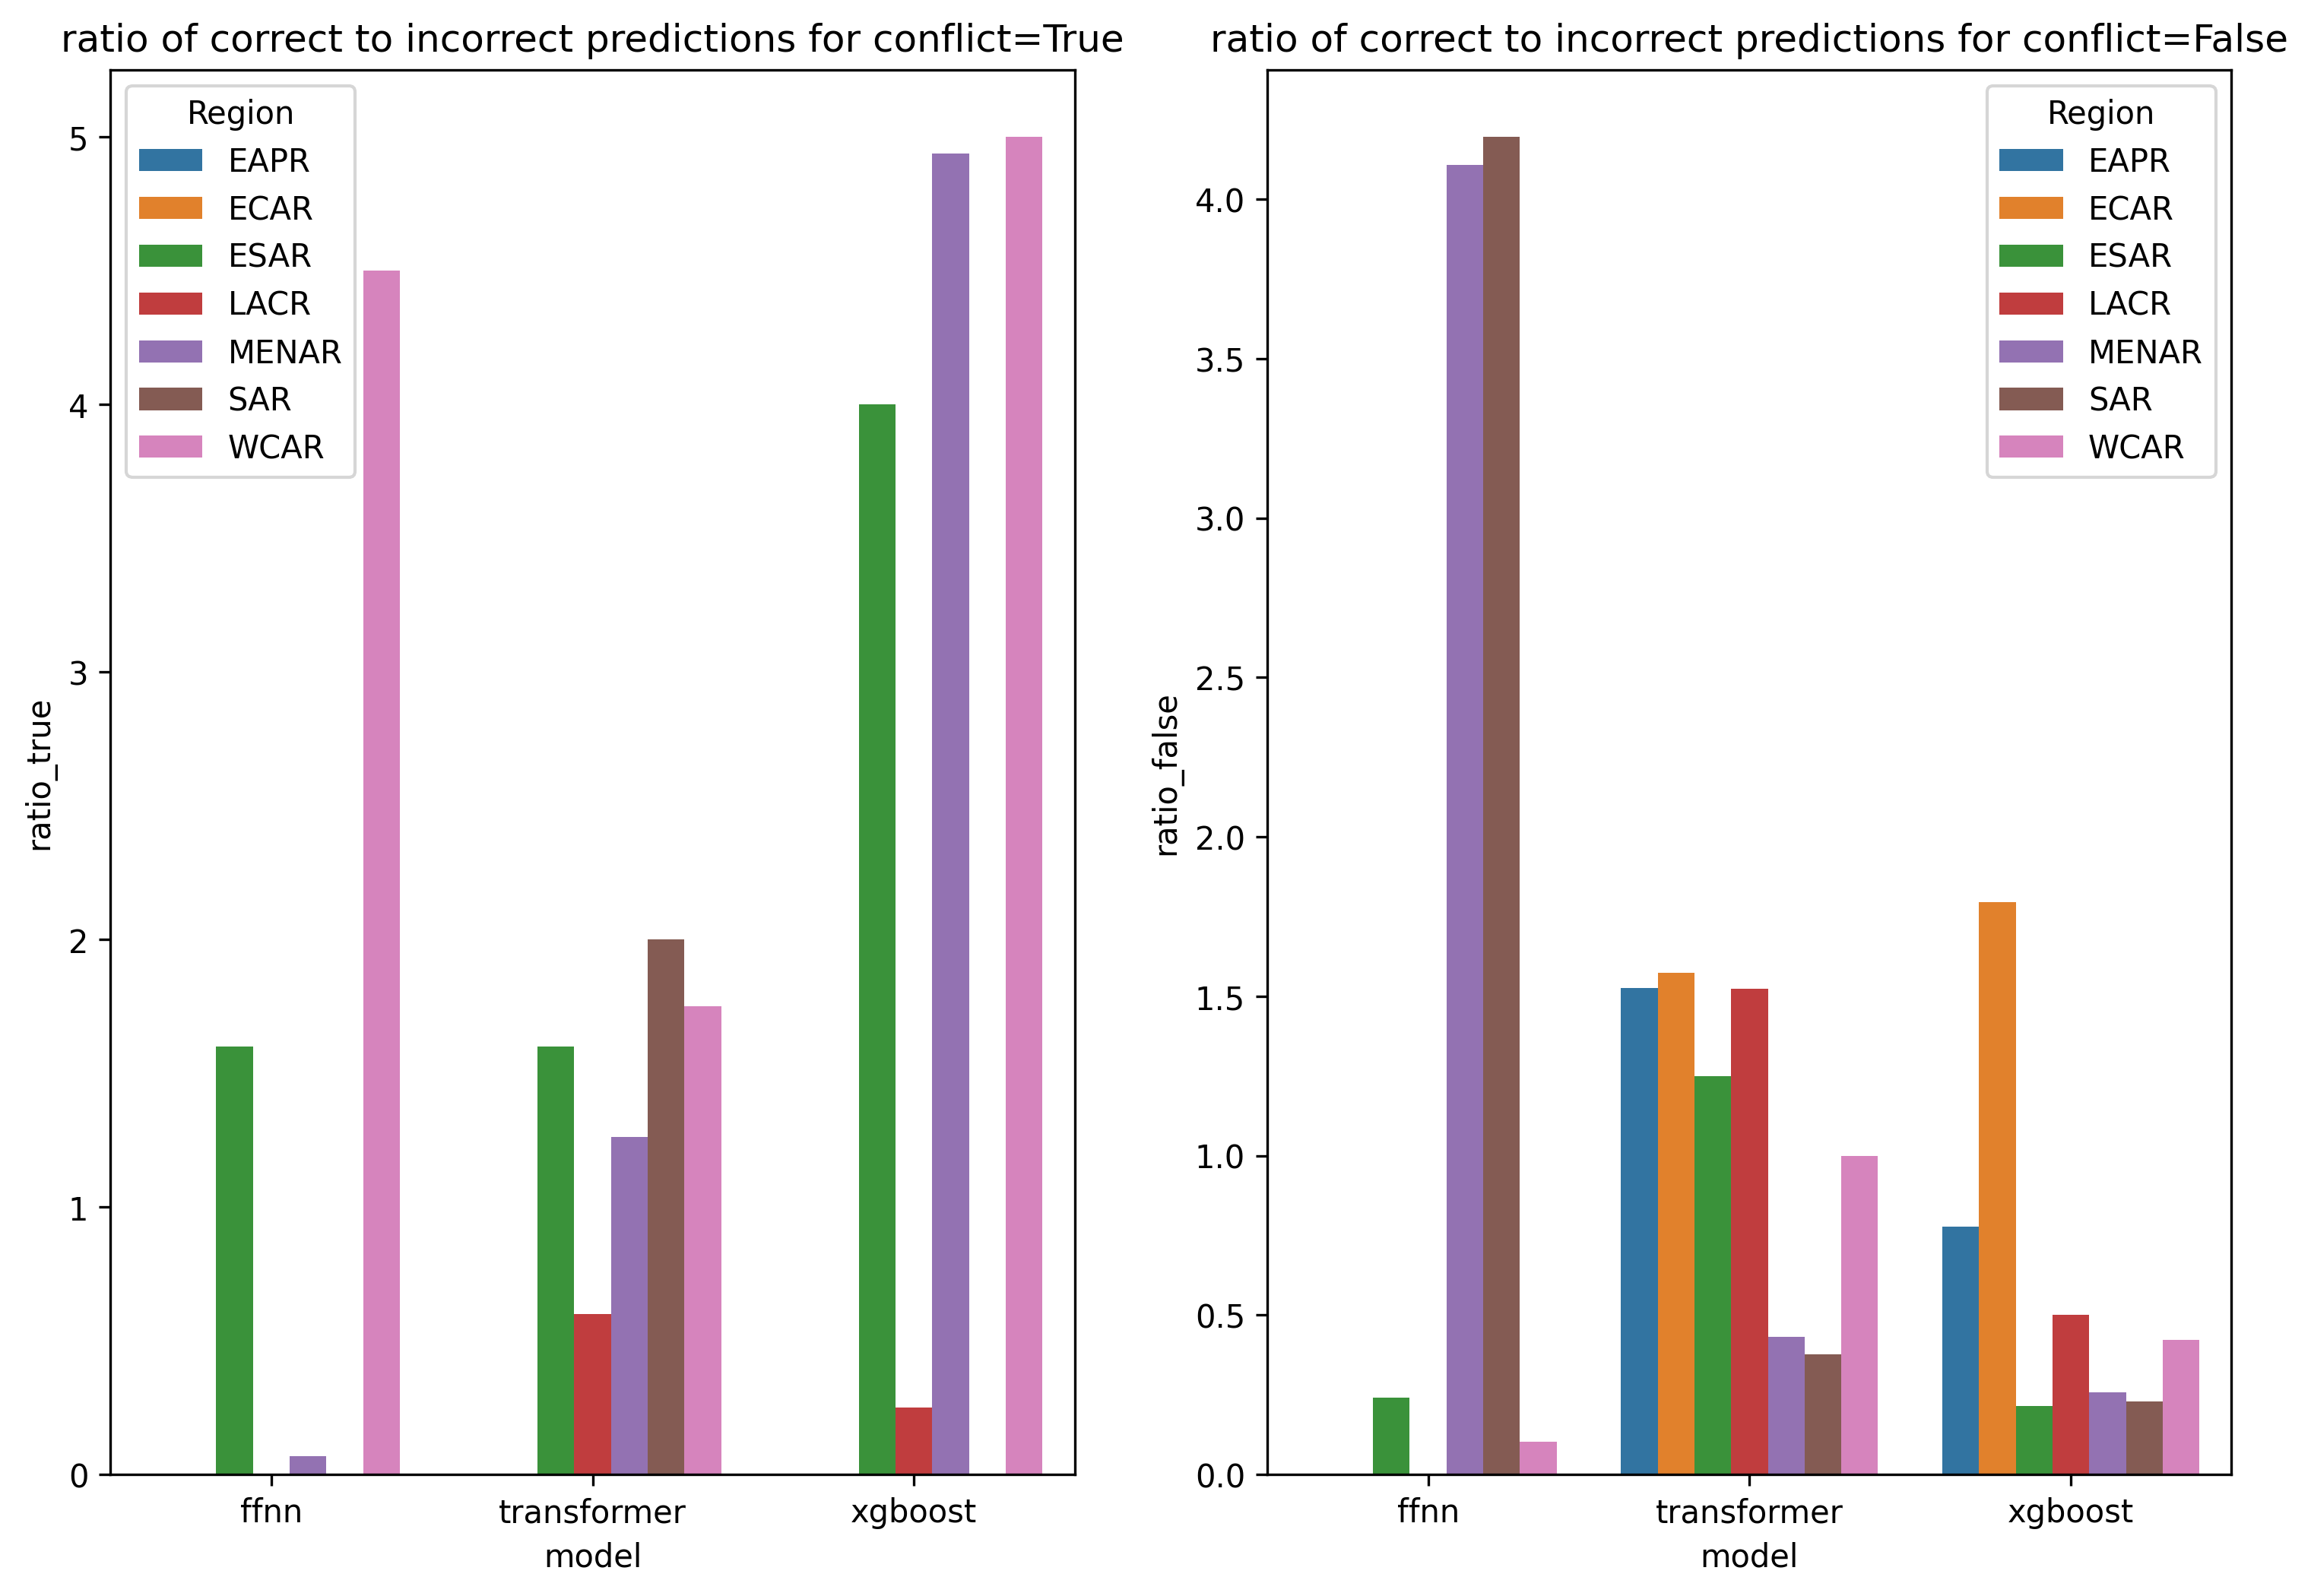

In [112]:
for dim in ['HDI', 'Income Group', 'Fragility', 'continent', 'Region',]:
    print(dim)
    df = _df_pc.groupby(['model', dim]).sum(numeric_only=True)[['correct', 'incorrect', 'correct_true', 'incorrect_true', 'correct_false', 'incorrect_false', ]]
    df['ratio'] = df['correct'] / (df['incorrect'])
    df['ratio_true'] = df['correct_true'] / (df['incorrect_true'])
    df['ratio_false'] = df['correct_false'] / (df['incorrect_false'])

    display(df.sort_values(by='ratio', ascending=False))
    df['ratio'] = df['ratio'].replace(np.inf, (df['ratio'].sort_values(ascending=False)[1]*2))
    df['ratio_true'] = df['ratio_true'].replace(np.inf, (df['ratio_true'].sort_values(ascending=False)[1]*2))
    df['ratio_false'] = df['ratio_false'].replace(np.inf, (df['ratio_false'].sort_values(ascending=False)[1]*2))

    df = df.reset_index()
    #sns.barplot(data=df, x=dim, y='ratio', hue='model')
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), dpi=300)
    ax[0].set_title('ratio of correct to incorrect predictions for conflict=True')
    sns.barplot(data=df, x='model', y='ratio_true', hue=dim, ax=ax[0])
    ax[1].set_title('ratio of correct to incorrect predictions for conflict=False')

    sns.barplot(data=df, x='model', y='ratio_false', hue=dim, ax=ax[1])
    plt.show()

In [113]:
# list of sklearn.metrics functions that expect args `y_true` and `y_pred`
# nice explanations here: https://neptune.ai/blog/evaluation-metrics-binary-classification
# cohen kappa: how much better is your model over the random classifier that predicts based on class frequencies
# matthews: a correlation between predicted classes and ground truth
bin_metrics = ['f1_score', 'precision_score', 'recall_score',
               'cohen_kappa_score', 'matthews_corrcoef']

out = list()

for m, df in dfs.items():
    for metric in bin_metrics:
        fun = operator.methodcaller(metric, df[meta[m]['y_true']],
                                    df[meta[m]['y_pred']])
        out.append((m, metric, fun(metrics), 'max'))
    out.append((m, 'roc_auc_score', metrics.roc_auc_score(df[meta[m]['y_true']],
                                                          df[meta[m]['y_pred_proba']]), 'max'))
    
    tn, fp, fn, tp = metrics.confusion_matrix(df[meta[m]['y_true']],
                                              df[meta[m]['y_pred']]).ravel()
    
    # how many predictions out of all positive predictions were incorrect
    false_discovery_rate = fp/ (tp + fp)
    out.append((m, 'false_discovery_rate', false_discovery_rate, 'min'))
    
    # how many observations predicted as positive are in fact positive
    positive_predictive_value = tp/ (tp + fp)
    out.append((m, 'positive_predictive_value', positive_predictive_value, 'max'))
    
    # how many predictions out of all negative predictions were correct
    negative_predictive_value = tn/ (tn + fn)
    out.append((m, 'negative_predictive_value', negative_predictive_value, 'max'))
       
    false_positive_rate = fp / (fp + tn)
    out.append((m, 'false_positive_rate', false_positive_rate, 'min'))
    
    false_negative_rate = fn / (tp + fn)
    out.append((m, 'false_negative_rate', false_negative_rate, 'min'))
    
    true_positive_rate = tp / (tp + fn)
    out.append((m, 'true_positive_rate', true_positive_rate, 'max'))
    
    true_negative_rate = tn / (tn + fp)
    out.append((m, 'true_negative_rate', true_negative_rate, 'max'))

In [114]:
max_best = ['true_negative_rate', 'negative_predictive_value', 'true_positive_rate',
            'positive_predictive_value', 'f1_score', 'precision_score',
            'recall_score', 'cohen_kappa_score', 'matthews_corrcoef' 'roc_auc_score',]
min_best = ['false_negative_rate', 'false_discovery_rate', 'false_positive_rate',]

In [199]:
mdisplay = {'ffnn': 'FFNN', 'xgboost': 'XGBoost', 'transformer': 'Transformer'}

In [115]:
model_metrics = pd.DataFrame(out, columns=('model', 'metric', 'value', 'best'))

In [302]:
model_metrics['metric'] = model_metrics['metric'].apply(lambda r: ' '.join(r.split('_')).title())

In [316]:
model_metrics['model'] = model_metrics['model'].map(mdisplay)

In [317]:
# max value for each metric
(model_metrics.loc[model_metrics[model_metrics.best=='max']
                   .groupby(["metric"])["value"]
                   .idxmax()][['metric', 'model', 'value']])

metric    model  value
29          Cohen Kappa Score     FFNN   0.12
26                   F1 Score     FFNN   0.32
17          Matthews Corrcoef  XGBoost   0.14
21  Negative Predictive Value  XGBoost   0.92
33  Positive Predictive Value     FFNN   0.26
27            Precision Score     FFNN   0.26
15               Recall Score  XGBoost   0.72
18              Roc Auc Score  XGBoost   0.69
38         True Negative Rate     FFNN   0.73
24         True Positive Rate  XGBoost   0.72

In [318]:
# min value for each metric
(model_metrics.loc[model_metrics[model_metrics.best=='min']
                   .groupby(["metric"])["value"]
                   .idxmin()][['metric', 'model', 'value']])

metric    model  value
32  False Discovery Rate     FFNN   0.74
23   False Negative Rate  XGBoost   0.28
35   False Positive Rate     FFNN   0.27

In [319]:
#| label: tbl-best-min-metrics-broken
#| layout-ncol: 1

# TODO not only do styles not work, but this makes one article
# column narrower than the other one :(

cm = sns.light_palette("red", as_cmap=True)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styler-Object-and-Customising-the-Display
# TODO styles/colors still not working? https://github.com/quarto-dev/quarto-cli/discussions/3964
styler = (model_metrics[model_metrics.best=='min'][['metric', 'model', 'value']]
            .sort_values('metric')
            .style
                .background_gradient(cmap=cm)
                .format(precision=3)
                .hide(axis="index"))
dfi.export(styler, 'imgs/tbl-best-min-metrics.png')
styler

In [320]:
print(model_metrics[model_metrics.best=='min'][['metric', 'model', 'value']]
               .sort_values('metric').to_markdown(index=False, floatfmt=".02f"))

| metric               | model       |   value |
|:---------------------|:------------|--------:|
| False Discovery Rate | Transformer |    0.80 |
| False Discovery Rate | XGBoost     |    0.83 |
| False Discovery Rate | FFNN        |    0.74 |
| False Negative Rate  | Transformer |    0.53 |
| False Negative Rate  | XGBoost     |    0.28 |
| False Negative Rate  | FFNN        |    0.59 |
| False Positive Rate  | Transformer |    0.30 |
| False Positive Rate  | XGBoost     |    0.51 |
| False Positive Rate  | FFNN        |    0.27 |


In [321]:
#| label: tbl-best-max-metrics-broken
#| layout-ncol: 1

# TODO not only do styles not work, but this makes one article
# column narrower than the other one :(

cm = sns.light_palette("green", as_cmap=True)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styler-Object-and-Customising-the-Display
# TODO styles/colors still not working? https://github.com/quarto-dev/quarto-cli/discussions/3964
styler = (model_metrics[model_metrics.best=='max'][['metric', 'model', 'value']]
             .sort_values('metric')
             .style
                .background_gradient(cmap=cm)
                .format(precision=3)
                .hide(axis="index"))
dfi.export(styler, 'imgs/tbl-best-max-metrics.png', table_conversion="selenium")
styler

In [326]:
out_metrics = ['Cohen Kappa Score', 'Roc Auc Score', 'True Positive Rate', 'True Negative Rate', 'F1 Score', 'Recall Score', 'Precision Score',]

In [327]:
print(model_metrics[model_metrics["metric"].isin(out_metrics)][model_metrics.best=='max'][['metric', 'model', 'value']]
             .sort_values('metric').to_markdown(index=False, floatfmt=".02f"))

| metric             | model       |   value |
|:-------------------|:------------|--------:|
| Cohen Kappa Score  | XGBoost     |    0.09 |
| Cohen Kappa Score  | FFNN        |    0.12 |
| Cohen Kappa Score  | Transformer |    0.11 |
| F1 Score           | FFNN        |    0.32 |
| F1 Score           | XGBoost     |    0.28 |
| F1 Score           | Transformer |    0.28 |
| Precision Score    | XGBoost     |    0.17 |
| Precision Score    | FFNN        |    0.26 |
| Precision Score    | Transformer |    0.20 |
| Recall Score       | XGBoost     |    0.72 |
| Recall Score       | Transformer |    0.47 |
| Recall Score       | FFNN        |    0.41 |
| Roc Auc Score      | Transformer |    0.64 |
| Roc Auc Score      | XGBoost     |    0.69 |
| Roc Auc Score      | FFNN        |    0.64 |
| True Negative Rate | Transformer |    0.70 |
| True Negative Rate | XGBoost     |    0.49 |
| True Negative Rate | FFNN        |    0.73 |
| True Positive Rate | FFNN        |    0.41 |
| True Positi

/var/folders/gw/2dw8mrhn68d45sb46j5j7wq00000gn/T/ipykernel_2322/2517435434.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(model_metrics[model_metrics["metric"].isin(out_metrics)][model_metrics.best=='max'][['metric', 'model', 'value']]


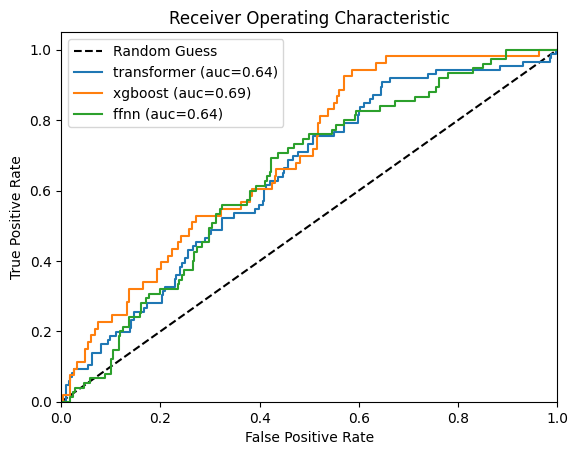

In [148]:
#| label: fig-roc
#| fig-cap: "Receiver operating characteristic"
#| fig-subcap: 
#|   - "Comparison of model ROC"
#| fig-alt:
#|   - "ROC plot of models"
#| layout-ncol: 1

plt.figure()
plt.plot([0,1],[0,1], "k--", label='Random Guess')

for m, df in dfs.items():
    fpr, tpr, _ = metrics.roc_curve(df[meta[m]['y_true']], df[meta[m]['y_pred_proba']])
    auc = metrics.roc_auc_score(df[meta[m]['y_true']], df[meta[m]['y_pred_proba']])
    plt.plot(fpr, tpr, label=f"{m} (auc={auc:.02f})")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
plt.legend(loc="best")
plt.savefig('imgs/fig-roc.png')
plt.show()

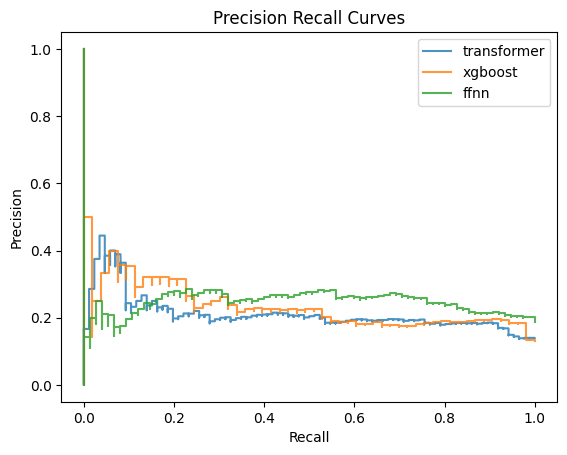

In [123]:
#| label: fig-prc
#| fig-cap: "Precision recall curve"
#| fig-subcap: 
#|   - "Comparison of model precision recall curves"
#| fig-alt:
#|   - "PRC plot of models"
#| layout-ncol: 1

ax = plt.gca()
for m, df in dfs.items():
    precision, recall, threshold = metrics.precision_recall_curve(df[meta[m]['y_true']], 
                                                                  df[meta[m]['y_pred_proba']])
    prd = metrics.PrecisionRecallDisplay(precision, recall)
    prd.plot(ax=ax, alpha=0.8, label=m)
plt.legend(loc="best")
plt.title('Precision Recall Curves')
plt.savefig('imgs/fig-prc.png')
plt.show()

In [124]:
for m, df in _dfs.items():
    print(df.shape)
    print(df.columns.values)

(615, 5)
['y_pred' 'y_pred_proba' 'y_true' 'model' 'iso3']
(406, 5)
['y_pred' 'y_pred_proba' 'y_true' 'model' 'iso3']
(403, 5)
['y_pred' 'y_pred_proba' 'y_true' 'model' 'iso3']


In [192]:
import matplotlib
# https://stackoverflow.com/a/63923910
c_low = matplotlib.colors.colorConverter.to_rgba('lightgreen', alpha = .5)
c_high = matplotlib.colors.colorConverter.to_rgba('green', alpha = 1)
cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('rb_cmap', [c_low, c_high], 512)

/opt/homebrew/Caskroom/miniforge/base/envs/magasin/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 4 classes. Setting k to 3.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/magasin/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 4 classes. Setting k to 3.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/magasin/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 4 classes. Setting k to 3.
  warnings.warn(


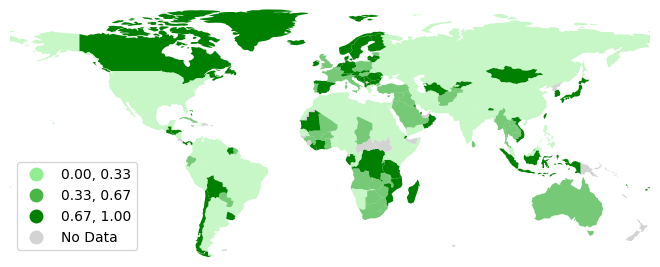

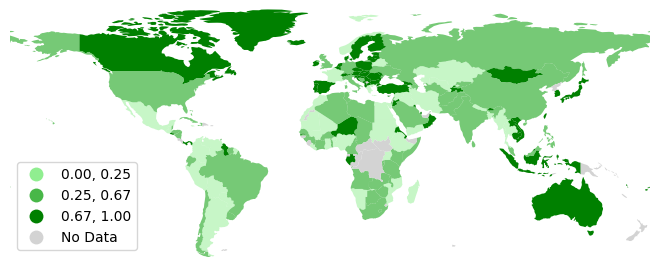

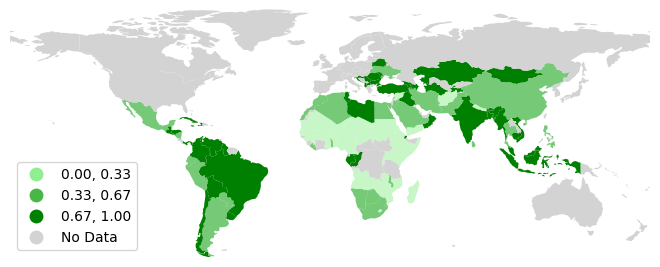

In [272]:
for m, df in _dfs.items():
    _df = df.reset_index()
    col = 'y_pred_proba'
    _df = _df[_df['yearmonth'].isin(common_yearmonths)]
    # World Equidistant Cylindrical projection
    _world = world[(world.pop_est>0) & (world.name!="Antarctica")].to_crs(epsg=4087)
    
    grouped = _df.groupby('iso3').apply(lambda g: metrics.accuracy_score(g['y_true'], g['y_pred']))
    grouped = pd.DataFrame(grouped.reset_index().rename(columns={0: 'accuracy'}), columns=('iso3', 'accuracy'))
    grouped =  _world.merge(grouped, left_on='iso_a3', right_on='iso3', how='outer')
    
    fig =  plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    
    #ax.set_title(f"{mdisplay[m]} model accuracy on test data")
    grouped.plot(column='accuracy', ax=ax, scheme='QUANTILES',
                 missing_kwds={'color': 'lightgrey', 'label': 'No Data'}, k=4, 
                 legend=True, legend_kwds={'loc': 'lower left'},
                 cmap=cmap_rb,)
    # https://stackoverflow.com/a/55162475
    ax.margins(0)
    ax.apply_aspect()
    bbox = ax.get_window_extent()._bbox
    w,h = fig.get_size_inches()
    fig.set_size_inches(w*bbox.width, h*bbox.height)
    plt.gcf().set_size_inches(w*bbox.width, h*bbox.height)
    ax.set_axis_off();
    
    plt.savefig(f'imgs/fig-{m}-test-accuracy.png', bbox_inches="tight", pad_inches=0, dpi=100)

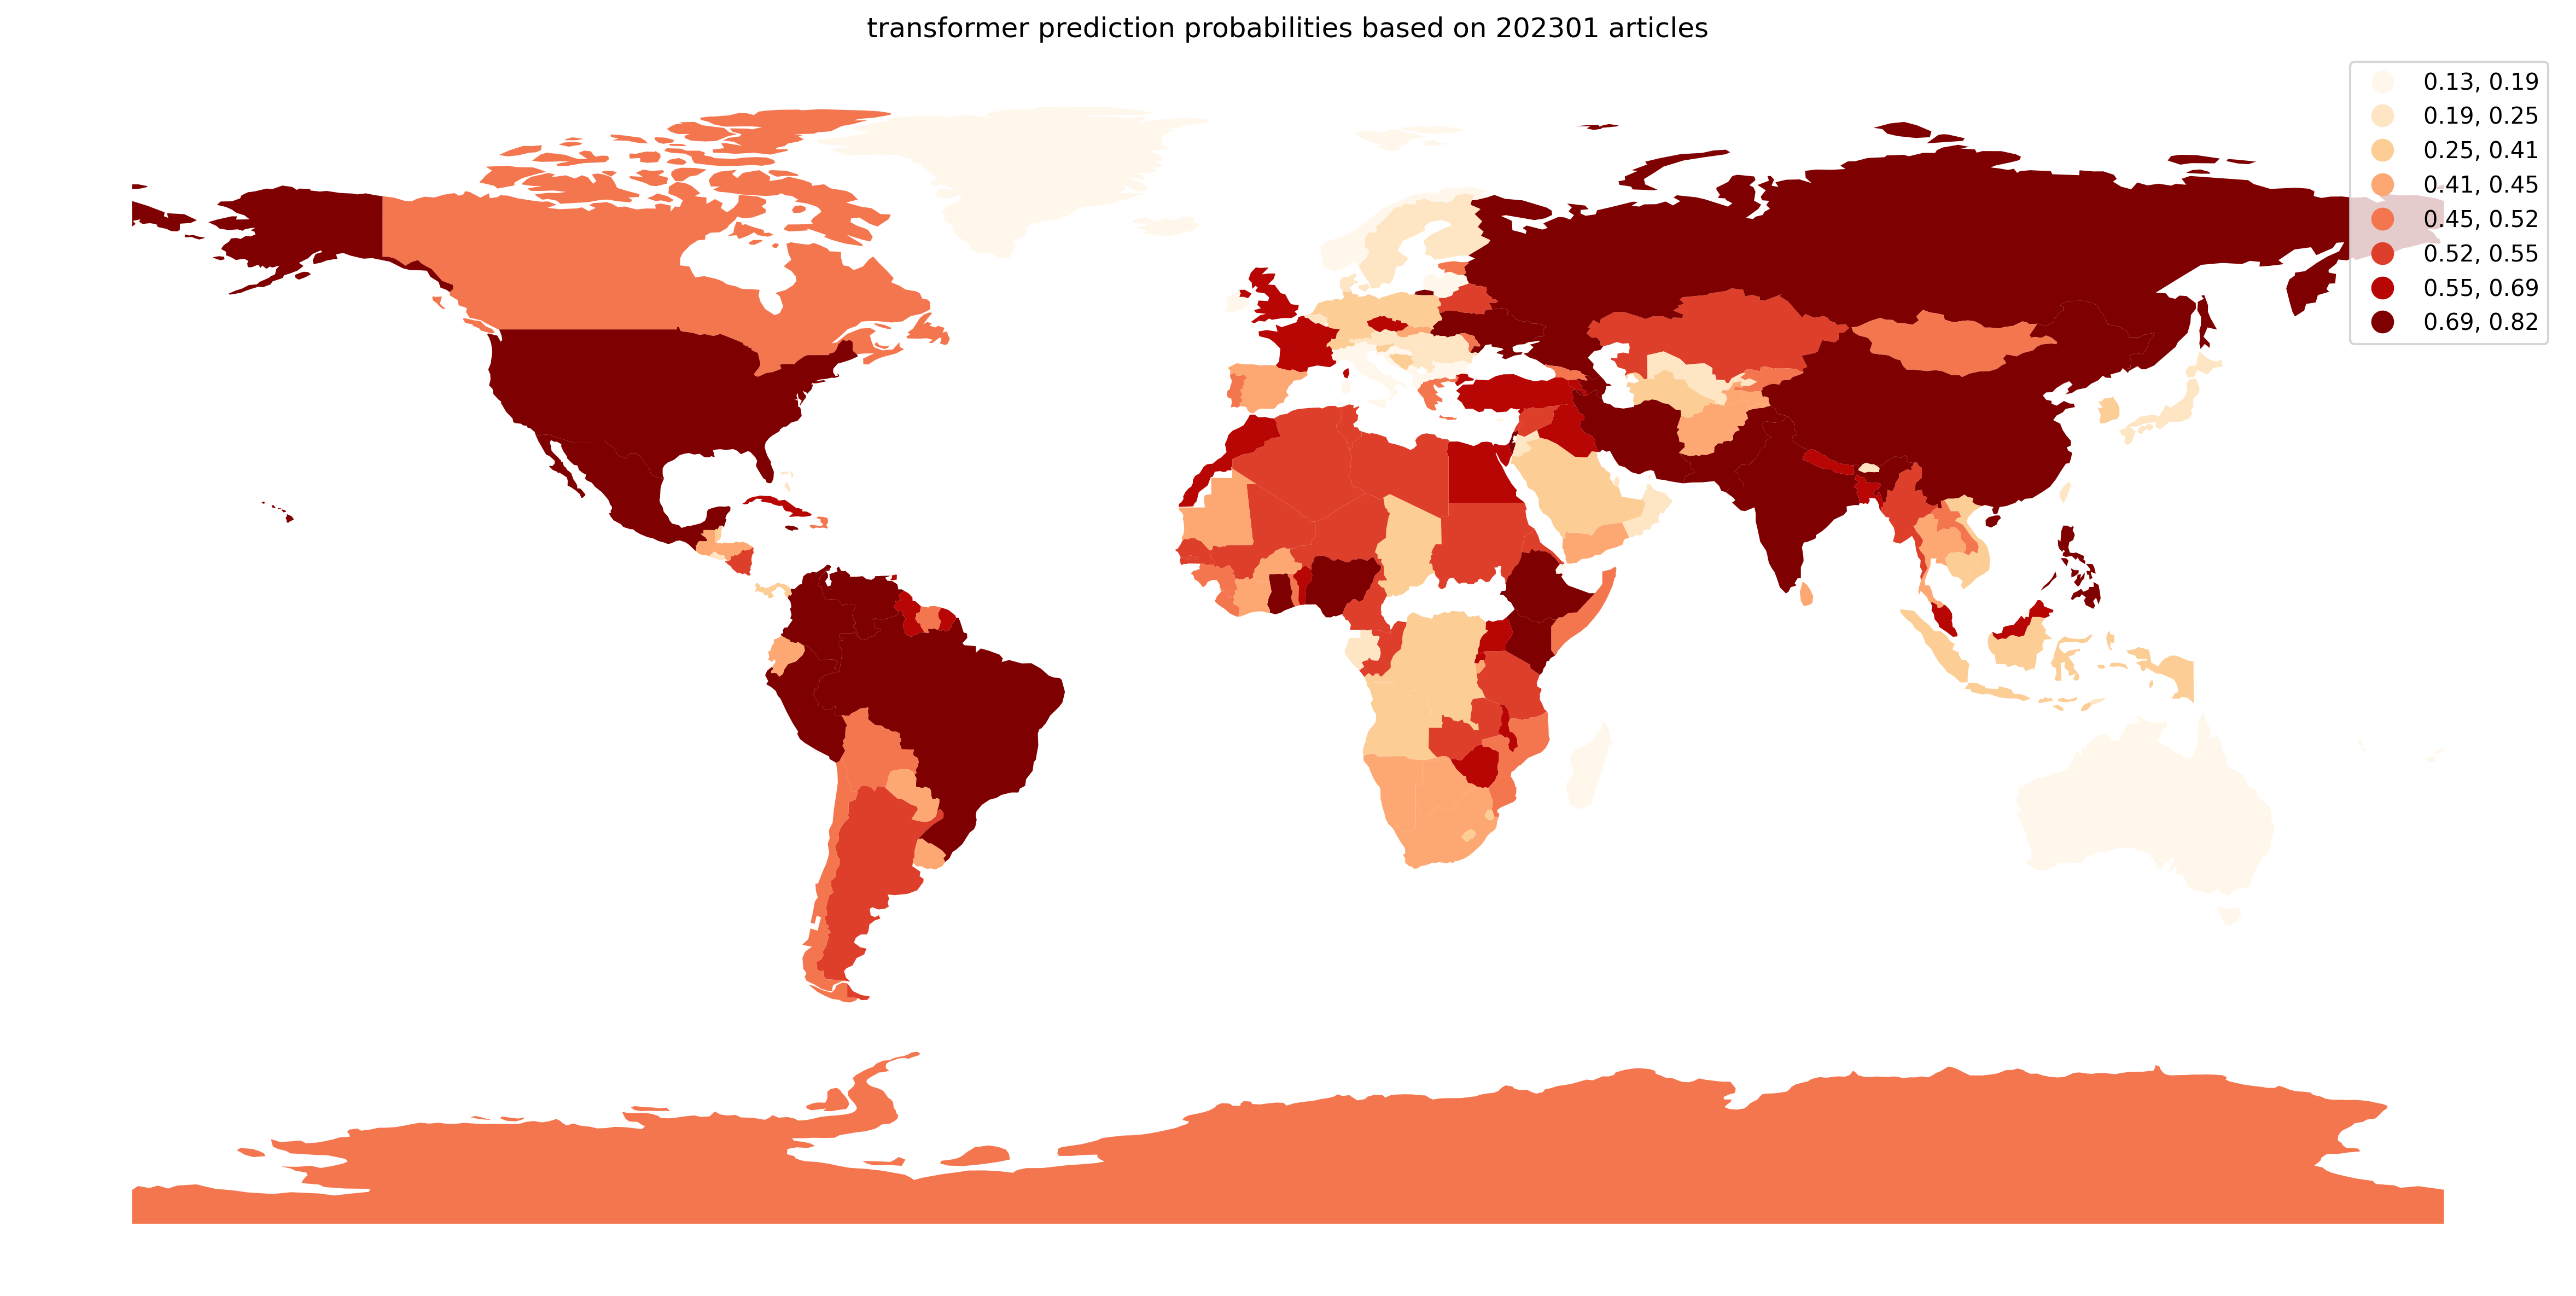

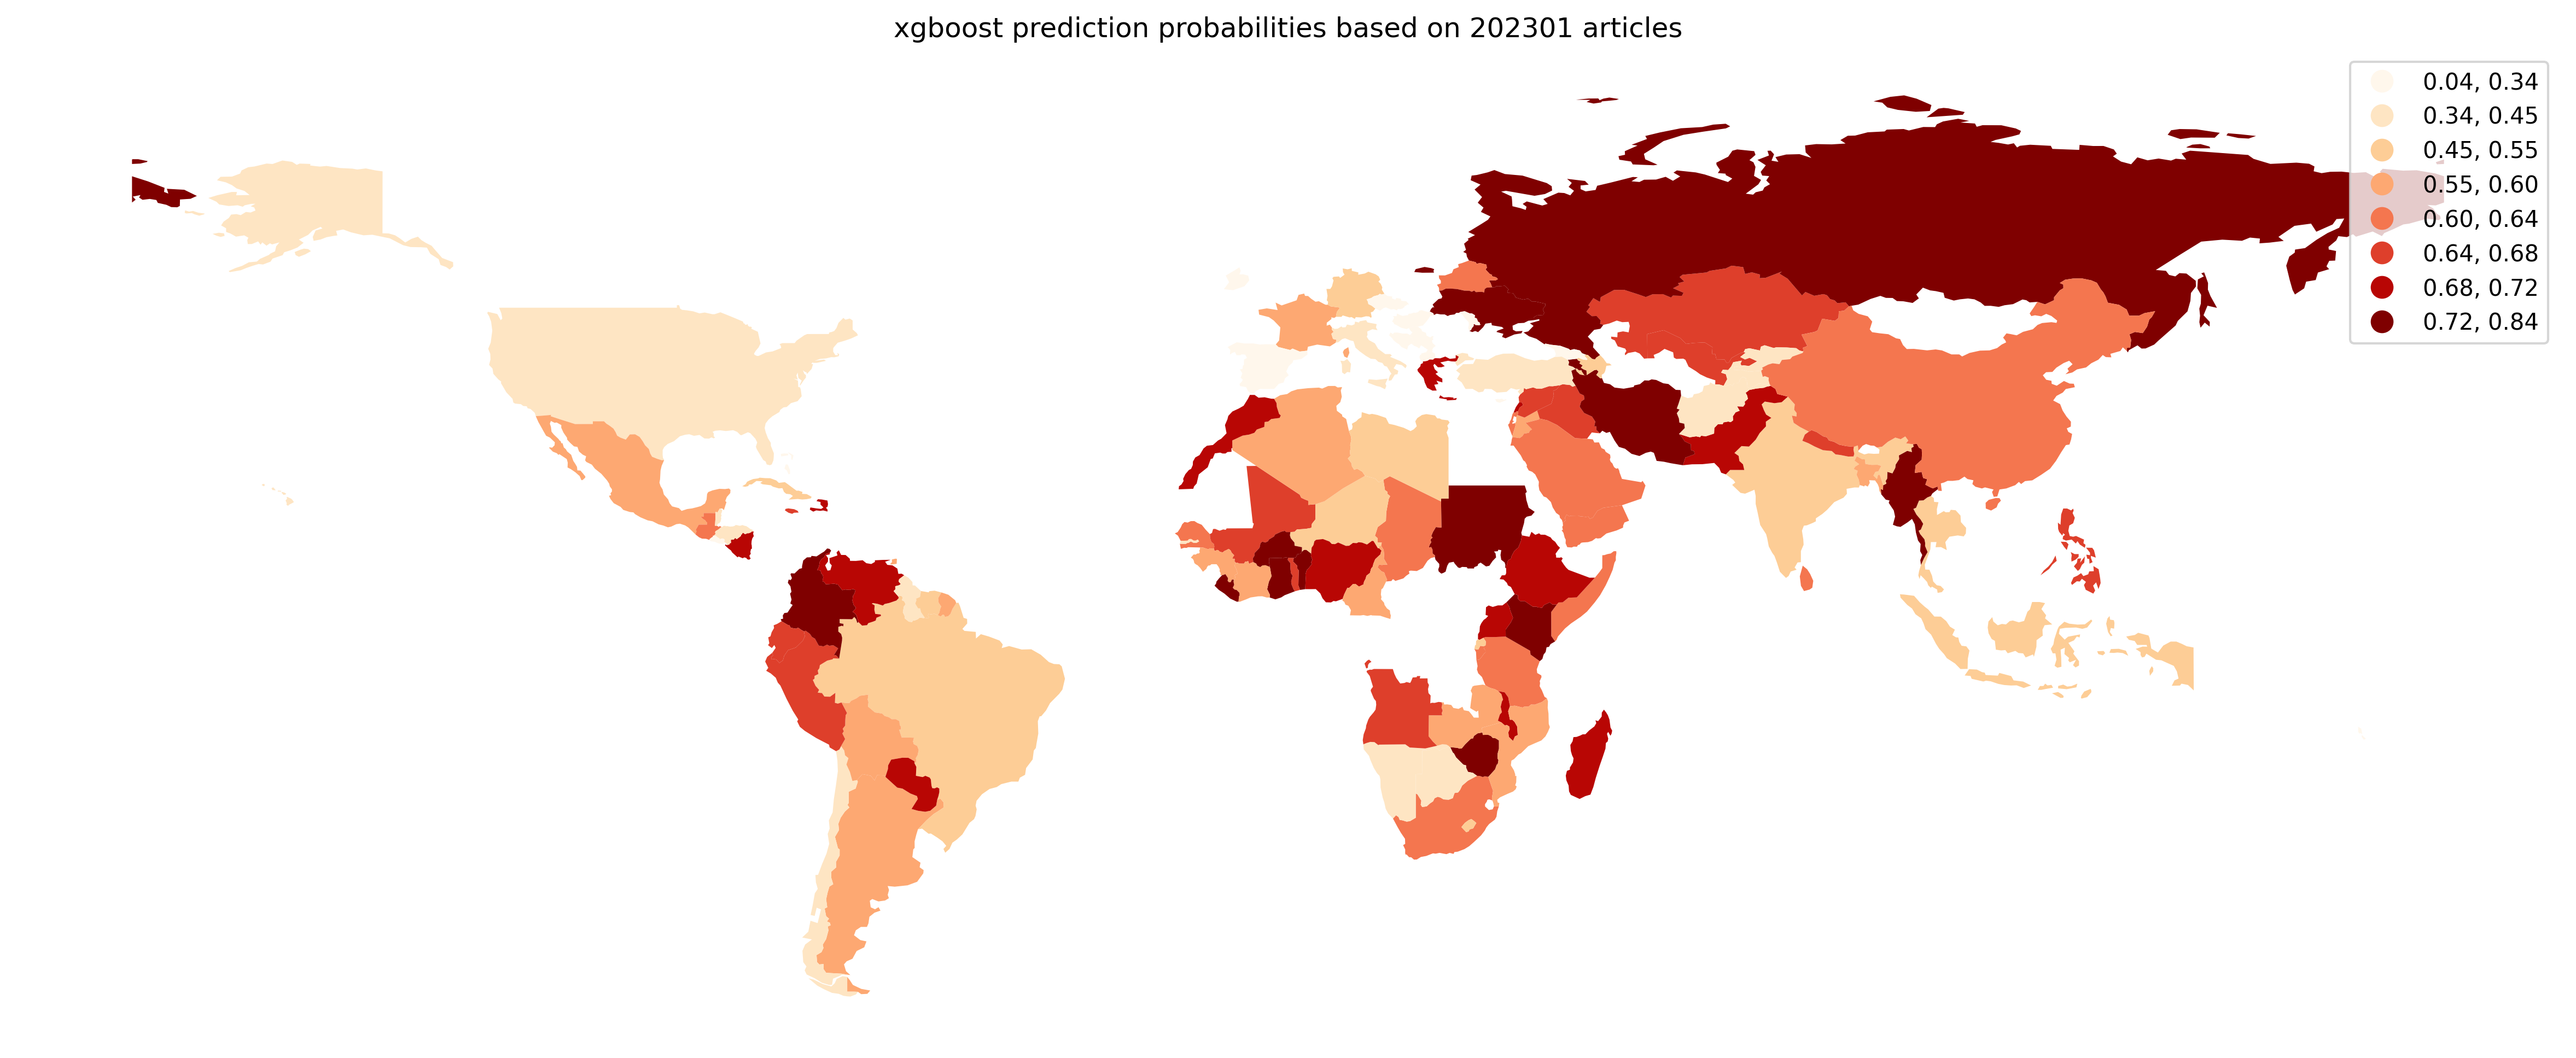

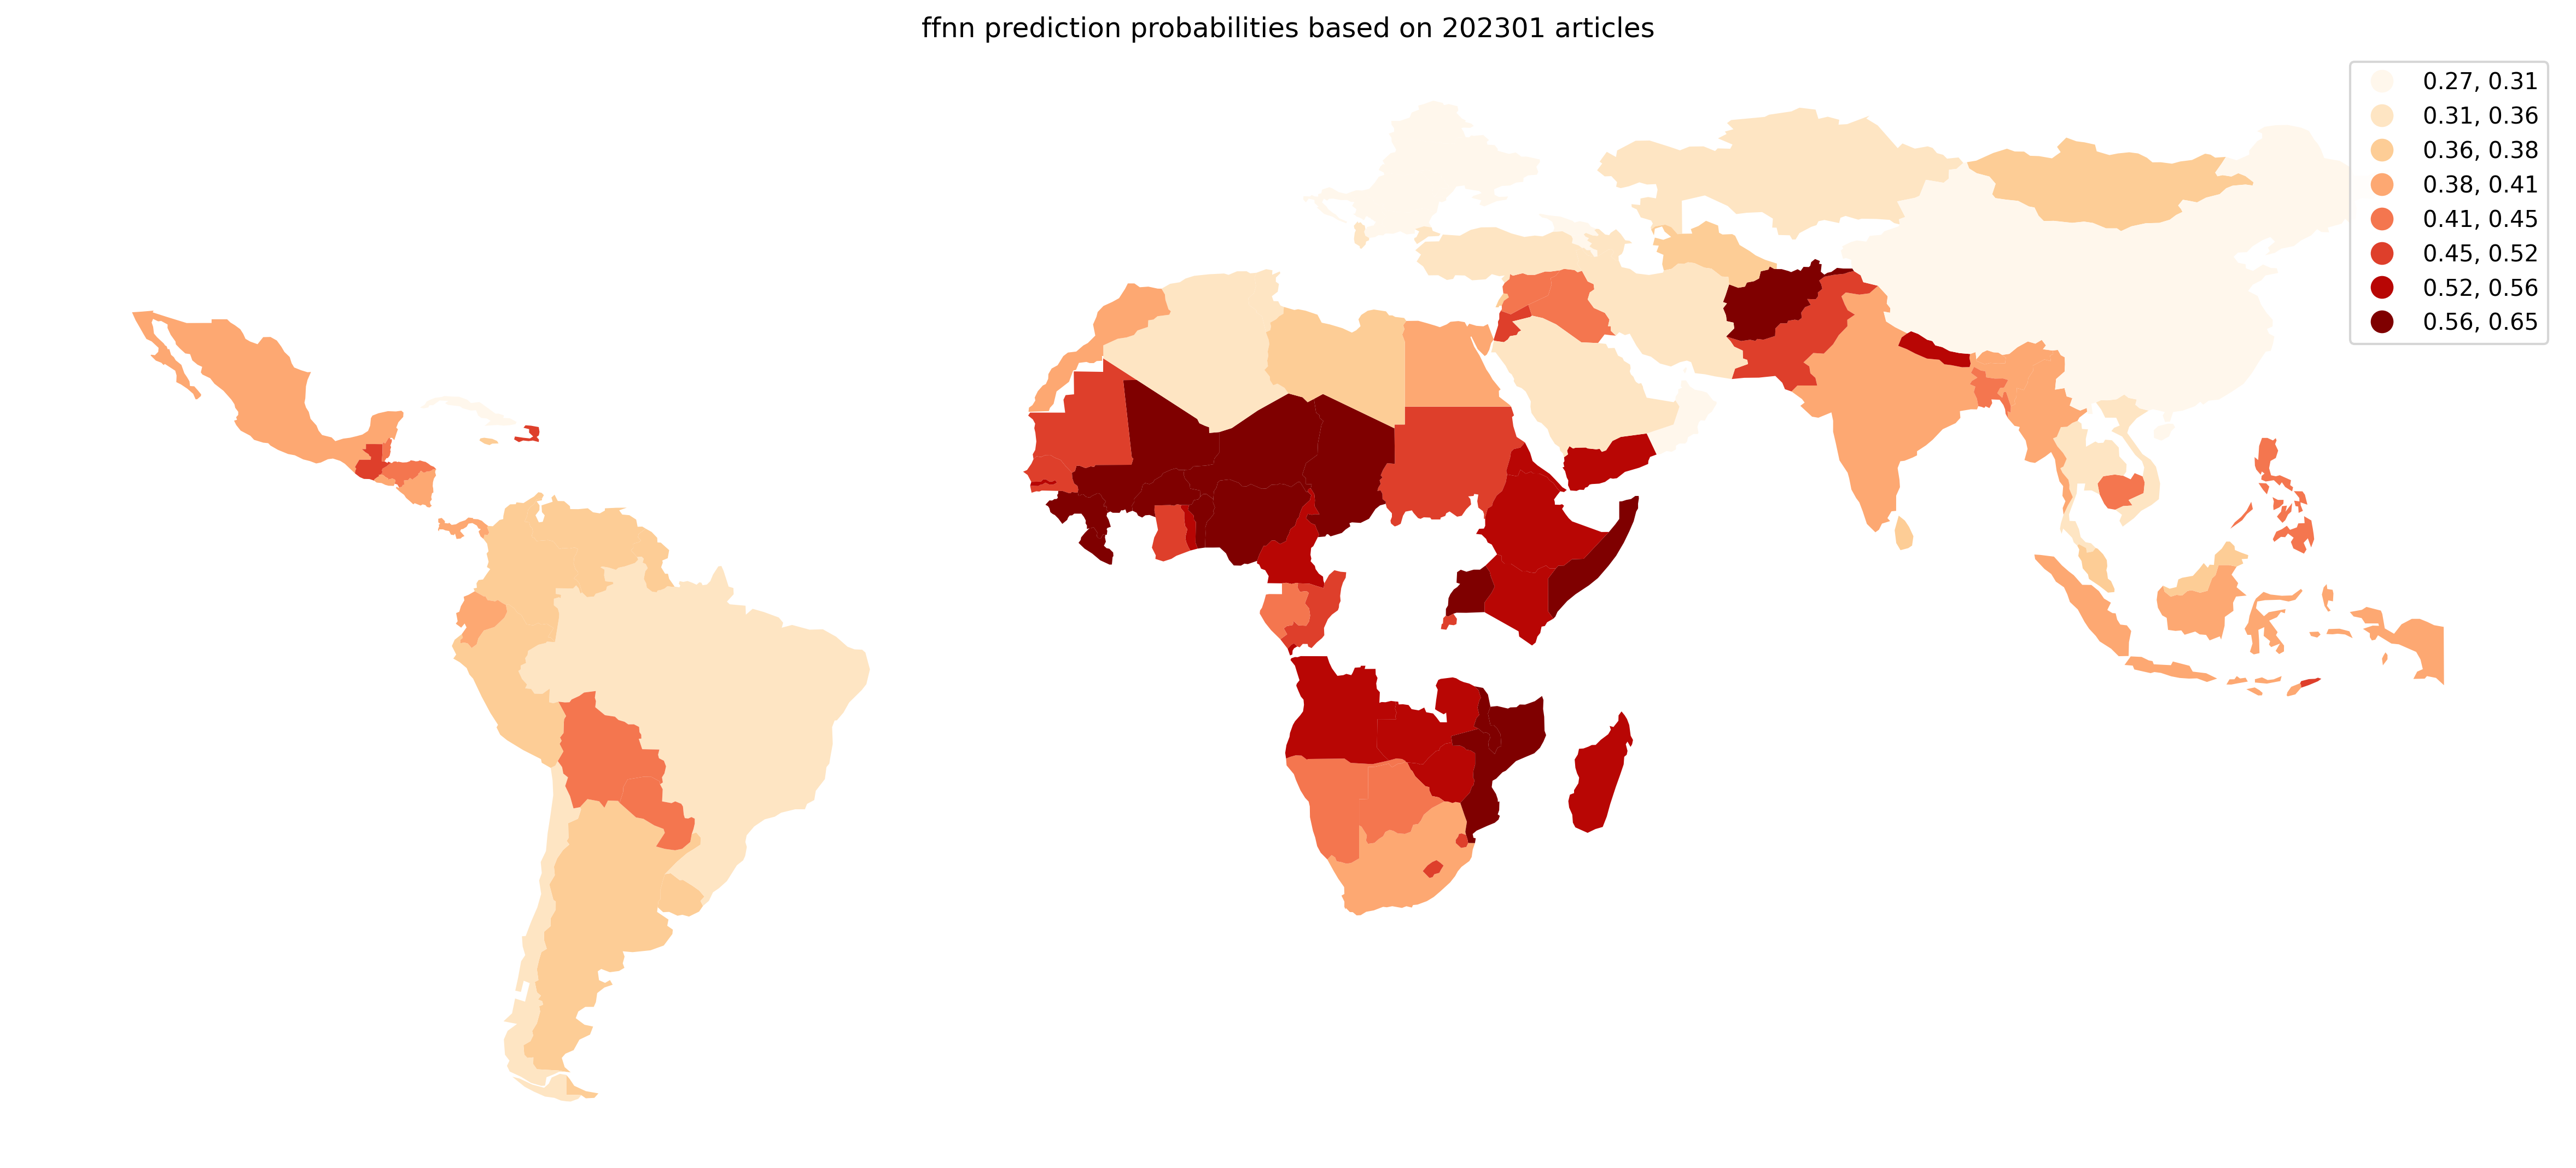

In [196]:
for m, df in _dfs.items():
    _df = df.reset_index()
    col = 'y_pred_proba'
    ym = '202301'
    _df = _df[_df['yearmonth'].isin([ym])]
    _df = world.merge(_df, right_on='iso3', left_on='iso_a3')

    fig, ax = plt.subplots(1, 1, figsize=(20, 18), dpi=300)
    ax.set_title(f"{m} prediction probabilities based on {ym} articles")
    _df.plot(column=col, ax=ax, scheme='QUANTILES', k=8, legend=True,
             cmap="OrRd")
    ax.set_axis_off();
    plt.savefig(f'imgs/fig-{col}-{m}-{ym}.png')

In [126]:
def tooltip_text(row):
    out = f"{row['iso3']}: &emsp;{row['y_true_t']} {row['y_true_x']} {row['y_true']}<br>"
    for m, pro, pre in [('transformer', 'y_pred_proba_t', 'y_pred_t'),
                        ('xgboost', 'y_pred_proba_x', 'y_pred_x'),
                        ('ffnn', 'y_pred_proba', 'y_pred')]:
        out += f"{m}: <br>&emsp;{row[pro]:.02f} ({row[pre]})<br>"
    return out

In [127]:
dfa = world.merge(_dfa.reset_index(), right_on='iso3', left_on='iso_a3')

In [128]:
dfa['tooltip'] = dfa.apply(tooltip_text, axis=1)

In [129]:
ym = '202301'
col = 'y_pred_proba'
_dfa = dfa[dfa['yearmonth'].isin([ym])]
#_dfa = _dfa.dropna()

In [130]:
print(dfa.shape)
print(dfa[dfa['yearmonth'].isin([ym])].shape)

(278, 24)
(79, 24)


In [131]:
_dfa.geometry[(_dfa.geometry.is_empty | _dfa.geometry.isna())]

GeoSeries([], Name: geometry, dtype: geometry)

In [132]:
_dfa.explore(
     column=col, # make choropleth based on this column
     tooltip="tooltip", # show "tooltip" value in tooltip (on hover)
     popup=True, # show all values in popup (on click)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap='OrRd',
     style_kwds=dict(color="darkgrey") # use darkgrey outline
)

In [133]:
df_reduced_2d = pd.read_feather('umap_reduced_2d.feather')

In [134]:
%%time
if not pathlib.Path('imgs/fig-umap2d-jointplot.png').exists():
    sns.jointplot(x=df_reduced_2d['one'], y=df_reduced_2d['two'], kind="kde")
    plt.savefig('imgs/fig-umap2d-jointplot.png')
    plt.show()

CPU times: user 27 µs, sys: 27 µs, total: 54 µs
Wall time: 55.8 µs


In [135]:
if not pathlib.Path('imgs/fig-umap2d-ds-targets.png').exists():
    cvs = ds.Canvas(plot_width=850, plot_height=500)
    agg = cvs.points(df_reduced_2d, 'one', 'two', agg=ds.by('label', ds.count()))
    img = ds.tf.shade(agg, cmap=colorcet.fire, how='log')
    export_image(img, "fig-umap2d-ds-targets", background="black", export_path="imgs/")
    img